In [277]:
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

##### import data

In [278]:
#ali_repo =pd.read_csv('data/CommitData/C_alibaba_weex.csv', sep=",") 

In [279]:
#repo=pd.read_csv('CommitData/C_0voice_campus_recruitmen_questions.csv', sep=",")

repo=pd.read_csv('data/CommitData/C_alibaba_weex.csv', sep=",")
#repo=pd.read_csv('data/CommitData/C_google_WebFundamentals.csv', sep=",")
#repo=pd.read_csv('data/CommitData/C_facebook_react.csv', sep=",")


In [280]:
repo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12044 entries, 0 to 12043
Data columns (total 13 columns):
 #   Column                                                                              Non-Null Count  Dtype 
---  ------                                                                              --------------  ----- 
 0   url                                                                                 12044 non-null  object
 1   sha                                                                                 12044 non-null  object
 2   owner                                                                               12044 non-null  object
 3   repo                                                                                12044 non-null  object
 4   author                                                                              11256 non-null  object
 5   date                                                                                12044 non-null  ob

### Data Cleaning


In [281]:
repo = repo.rename(columns={'fileTuples<fileName. status. additions. deletions. changes. raw_url. contents_url>': 'fileTuple'})
repo['net_code_change'] = repo['totalAdditions'] - repo['totalDeletions']
repo = repo[['url', 'repo', 'author', 'date','totalAdditions',
       'totalDeletions','net_code_change', 'message', 'numFiles', 'numComments',
       'fileTuple']]

repo = repo.sort_values(by='date', ascending=True)

In [282]:
# Sort the data by date to ensure correct calculations
repo.sort_values(by='date', inplace=True)

In [283]:
import numpy as np

# Convert the 'date' column to datetime
repo['date'] = pd.to_datetime(repo['date'])

# Sort the data by date to ensure correct calculations
repo.sort_values(by='date', inplace=True)

# Calculate commit frequency per month
repo['month'] = repo['date'].dt.to_period('M')
monthly_commits = repo.groupby('month').size().rename('monthly_commits')
# Calculate the number of unique authors per month
monthly_unique_authors = repo.groupby('month')['author'].nunique().rename('monthly_unique_authors')

# Calculate total additions and deletions per month
monthly_additions = repo.groupby('month')['totalAdditions'].sum().rename('monthly_additions')
monthly_deletions = repo.groupby('month')['totalDeletions'].sum().rename('monthly_deletions')

# Calculate code churn
repo['code_churn'] = repo['totalAdditions'] + repo['totalDeletions']

# Join all the calculated features into the original dataframe
repo = repo.set_index('month').join([monthly_commits, monthly_unique_authors, monthly_additions, monthly_deletions])

# Reset index to flatten the dataframe
repo.reset_index(inplace=True)

# Calculate the average time between commits
repo['time_between_commits'] = repo['date'].diff().dt.total_seconds().div(3600).fillna(0)

C:\Users\ethan\AppData\Local\Temp\ipykernel_14628\2028832655.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  repo['month'] = repo['date'].dt.to_period('M')


In [284]:
repo.head(1)

,month,url,repo,author,date,totalAdditions,totalDeletions,net_code_change,message,numFiles,numComments,fileTuple,code_churn,monthly_commits,monthly_unique_authors,monthly_additions,monthly_deletions,time_between_commits
0,2016-03,https://api.github.com/repos/alibaba/weex/comm...,weex,lvscar,2016-03-11 10:18:12+00:00,203,0,203,Initial commit,2,0,"[('LICENSE', 'added', 201, 0, 201, 'https://gi...",203,1,1,203,0,0.0


In [285]:
repo.isnull().sum()

month                       0
url                         0
repo                        0
author                    788
date                        0
totalAdditions              0
totalDeletions              0
net_code_change             0
message                     0
numFiles                    0
numComments                 0
fileTuple                   0
code_churn                  0
monthly_commits             0
monthly_unique_authors      0
monthly_additions           0
monthly_deletions           0
time_between_commits        0
dtype: int64

In [286]:
# Save the enriched dataframe to a new CSV file
repo.to_csv('Data/ml_data/Ali_baba_commit_pb.csv', index=False)

#### AR1 Times Series

### Arima model (AR1)


In [287]:
df = repo

#### Step 2: check for stationarity

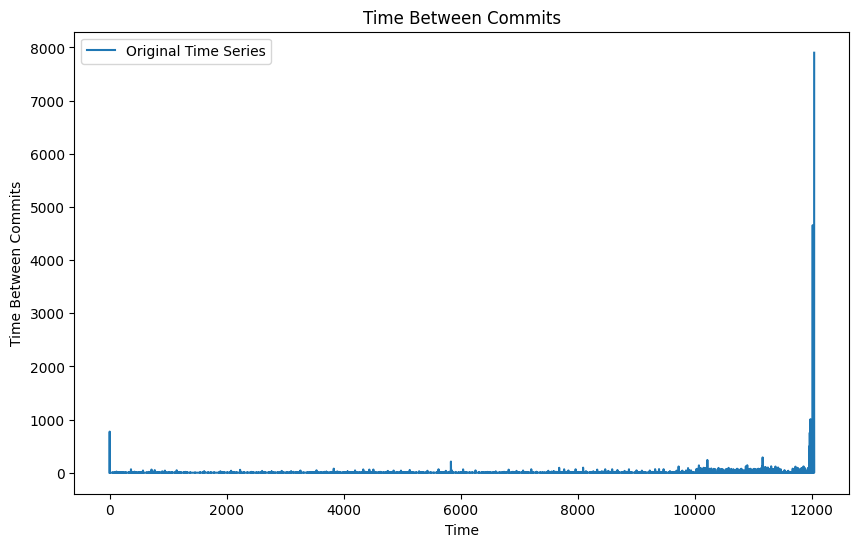

In [288]:
import matplotlib.pyplot as plt

# Plot the original series
plt.figure(figsize=(10, 6))
plt.plot(repo['time_between_commits'], label='Original Time Series')
plt.title('Time Between Commits')
plt.xlabel('Time')
plt.ylabel('Time Between Commits')
plt.legend()
plt.show()


In [289]:
#Step 2: Check for Stationarity


from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Assuming 'time_between_commits' is your Pandas Series or a column in your DataFrame
check_stationarity(repo['time_between_commits'])


Results of Dickey-Fuller Test:
Test Statistic                    20.379823
p-value                            1.000000
#Lags Used                        40.000000
Number of Observations Used    12003.000000
Critical Value (1%)               -3.430895
Critical Value (5%)               -2.861781
Critical Value (10%)              -2.566898
dtype: float64


#### Apply Differencing

In [290]:
#apply differencing
repo['diff_time_between_commits'] = repo['time_between_commits'].diff().dropna()


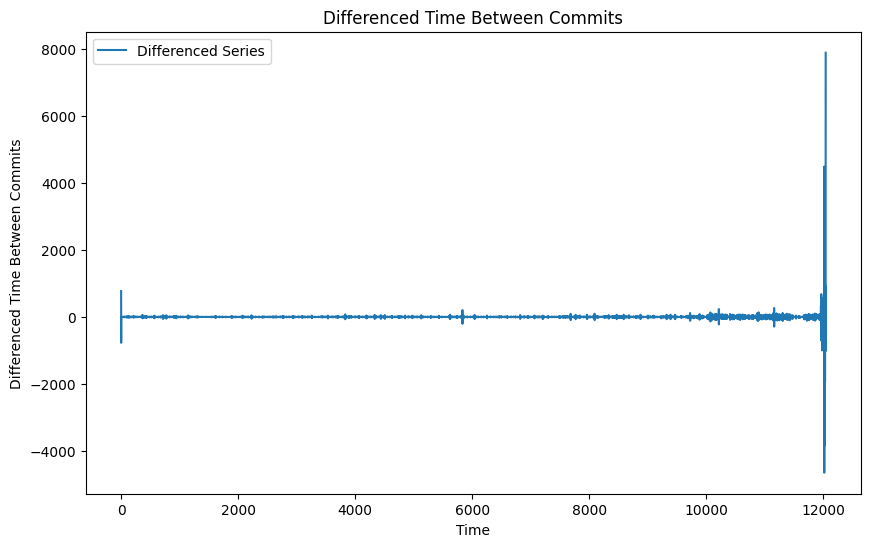

In [291]:

plt.figure(figsize=(10, 6))
plt.plot(repo['diff_time_between_commits'], label='Differenced Series')
plt.title('Differenced Time Between Commits')
plt.xlabel('Time')
plt.ylabel('Differenced Time Between Commits')
plt.legend()
plt.show()


#### Step 4: Fit the AR1 Model 

In [292]:
#Step 4: Fit the AR(1) Model

from statsmodels.tsa.ar_model import AutoReg

# Choose the right series based on the stationarity test
series_to_model = repo['diff_time_between_commits']

# Remove any NaN values that might have been introduced by differencing
series_to_model = series_to_model.dropna()

model = AutoReg(series_to_model, lags=1)
model_fitted = model.fit()


C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [293]:
# Forecast the next value
forecast = model_fitted.predict(start=len(series_to_model), end=len(series_to_model))
print(forecast)


12043   -3938.462606
dtype: float64


C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


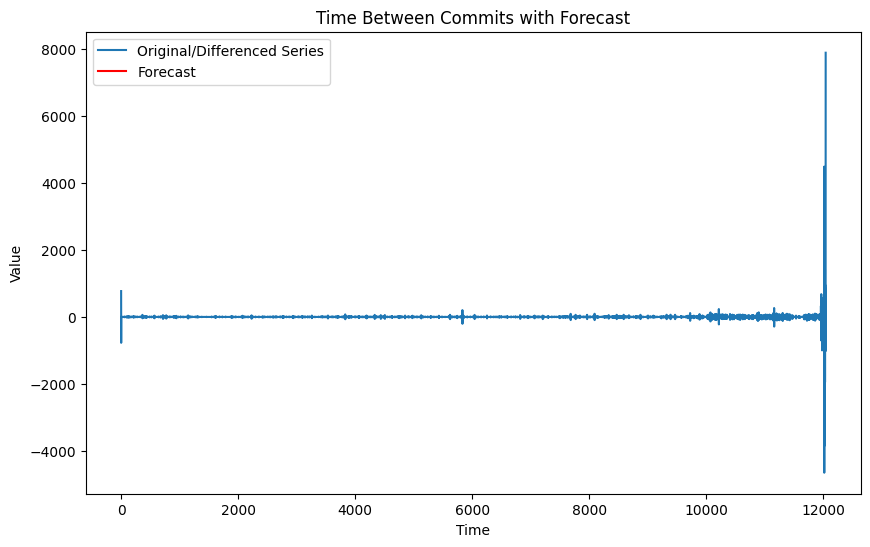

In [294]:
# Assuming 'forecast' contains the forecasted value(s) for the next time point(s)
# Extend the series or create a new series for plotting
forecast_series = pd.Series(forecast, index=[len(series_to_model) + i for i in range(len(forecast))])

# Plot original or differenced series with forecast
plt.figure(figsize=(10, 6))
plt.plot(series_to_model, label='Original/Differenced Series')
plt.plot(forecast_series, 'r', label='Forecast')
plt.title('Time Between Commits with Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


In [295]:
# Model summary
print(model_fitted.summary())

# Check residuals
residuals = model_fitted.resid
print('Residuals mean:', residuals.mean())


                                AutoReg Model Results                                
Dep. Variable:     diff_time_between_commits   No. Observations:                12043
Model:                            AutoReg(1)   Log Likelihood              -72963.966
Method:                      Conditional MLE   S.D. of innovations            103.564
Date:                       Tue, 13 Feb 2024   AIC                         145933.933
Time:                               13:21:50   BIC                         145956.121
Sample:                                    1   HQIC                        145941.374
                                       12043                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.5920      0.944      0.627      0.530      -1.258       2.442
diff_time_between_com

In [296]:
#method 2 

#### stationary test and differenceing

In [297]:
from statsmodels.tsa.stattools import adfuller

# Conducting Augmented Dickey-Fuller test to check for stationarity
adf_result = adfuller(repo['time_between_commits'])

# Extracting the test statistic and p-value
adf_statistic, p_value = adf_result[0], adf_result[1]

# Displaying the results
adf_statistic, p_value


(20.379823400226385, 1.0)

In [298]:
# Differencing the data
df_diff = repo['time_between_commits'].diff().dropna()

# Conducting the ADF test again on the differenced data
adf_result_diff = adfuller(df_diff)

# Extracting the test statistic and p-value for the differenced data
adf_statistic_diff, p_value_diff = adf_result_diff[0], adf_result_diff[1]

# Displaying the results for the differenced data
adf_statistic_diff, p_value_diff


(-7.051772661810239, 5.50297806874621e-10)

C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. fore

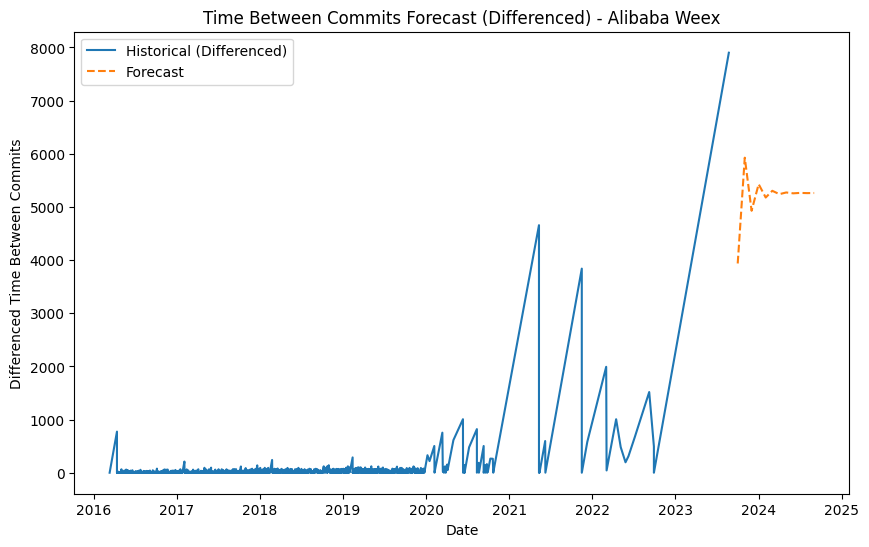

In [299]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

# Ensure the date column is in datetime format (if it's not already)
df['date'] = pd.to_datetime(df['date'])

# Set the date column as the index if it's not already
df.set_index('date', inplace=True)


model_diff = ARIMA(repo['time_between_commits'], order=(1, 1, 0))
model_fit_diff = model_diff.fit()

# Forecasting the next 5 months based on the differenced model
# Change 'steps=5' to the number of months you want to forecast
forecast_diff = model_fit_diff.forecast(steps=12)

# Find the last date in the historical data
last_date = repo.index[-1]

# Create a new date range for the forecast that continues from the last date, using 'MS' for month start
forecast_dates = pd.date_range(start=last_date, periods=len(forecast_diff)+1, freq='MS')[1:]

# Plotting the historical data and forecast
plt.figure(figsize=(10, 6))
plt.plot(repo.index, repo['time_between_commits'], label='Historical (Differenced)')
plt.plot(forecast_dates, forecast_diff, label='Forecast', linestyle='--')
plt.title('Time Between Commits Forecast (Differenced) - Alibaba Weex')
plt.xlabel('Date')
plt.ylabel('Differenced Time Between Commits')
plt.legend()
plt.show()


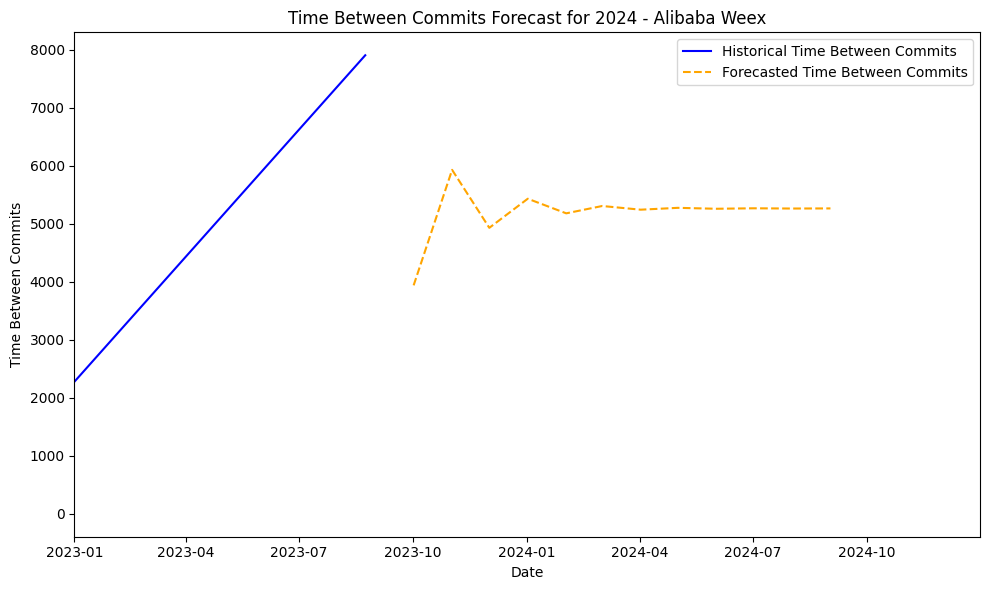

In [300]:
# Plotting the historical data and forecast
plt.figure(figsize=(10, 6))
# Historical data: using a solid blue line
plt.plot(repo.index, repo['time_between_commits'], label='Historical Time Between Commits', color='blue')
# Forecast data: using a dashed orange line
plt.plot(forecast_dates, forecast_diff, label='Forecasted Time Between Commits', color='orange', linestyle='--')

# Formatting the plot to be similar to the provided graph
plt.title('Time Between Commits Forecast for 2024 - Alibaba Weex')
plt.xlabel('Date')
plt.ylabel('Time Between Commits')
plt.legend()

# Optionally, limit the x-axis to focus on the forecast period more closely
# This would require knowledge of the specific date range you want to focus on
plt.xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2024-12-31'))

# Improve the layout and display the plot
plt.tight_layout()
plt.show()

In [301]:
forecast_diff


12044    3936.314372
12045    5926.261902
12046    4927.435222
12047    5428.782479
12048    5177.138148
12049    5303.447544
12050    5240.048287
12051    5271.870669
12052    5255.897864
12053    5263.915193
12054    5259.891005
12055    5261.910890
Name: predicted_mean, dtype: float64

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

# Simulating the "date" and "time_between_commits" data based on your provided sample
data = {
    "date": pd.date_range(start="2016-03-11", periods=5, freq='D'),
    "time_between_commits": [0.0, 773.051667, 0.0, 0.020278, 0.626389]
}
df = pd.DataFrame(data)
df.set_index("date", inplace=True)



# Assuming the data is already stationary or has been differenced accordingly (d=0 for simplicity)
# We will fit an ARIMA model with parameters (p=1, d=0, q=0) - essentially an AR(1) model

model = ARIMA(df['time_between_commits'], order=(1, 0, 0))
model_fit = model.fit()

# Forecasting the next 5 days
forecast = model_fit.forecast(steps=5)

# Plotting the historical data and forecast
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['time_between_commits'], label='Historical')
plt.plot(pd.date_range(start=df.index[-1], periods=6, freq='D')[1:], forecast, label='Forecast', linestyle='--')
plt.title('Time Between Commits Forecast')
plt.xlabel('Date')
plt.ylabel('Time Between Commits')
plt.legend()
plt.show()


In [109]:
df.head(1)

,month,url,repo,author,date,totalAdditions,totalDeletions,net_code_change,message,numFiles,numComments,fileTuple,code_churn,monthly_commits,monthly_unique_authors,monthly_additions,monthly_deletions,time_between_commits,diff_time_between_commits
0,2016-03,https://api.github.com/repos/alibaba/weex/comm...,weex,lvscar,2016-03-11 10:18:12+00:00,203,0,203,Initial commit,2,0,"[('LICENSE', 'added', 201, 0, 201, 'https://gi...",203,1,1,203,0,0.0,NaN


In [60]:
df['date'] = pd.to_datetime(df['date'])  # Convert the 'date' column to DateTime
df.set_index('date', inplace=True)  # Set the 'date' column as the index
time_series = df['time_between_commits']  # Assuming this column exists in your DataFrame


In [61]:
# Generate a date range for the forecasts
forecast_index = pd.date_range(start=time_series.index[-1], periods=len(forecasts_diff)+1, closed='right')

# Create a DataFrame for the forecasts to easily plot them
forecasts_df = pd.DataFrame(forecasts_original_scale, index=forecast_index, columns=['Forecast'])


TypeError: _generate_range() got an unexpected keyword argument 'closed'

In [ ]:
plt.figure(figsize=(14, 7))

# Plot the original series
plt.plot(time_series.index, time_series, label='Original Series')

# Plot the differenced series
plt.plot(time_series_diff.index, time_series_diff, label='Differenced Series', alpha=0.7)

# Plot the forecasts
plt.plot(forecasts_df.index, forecasts_df['Forecast'], label='Forecasts', color='red')

plt.legend()
plt.title('Time Series Analysis with Forecasts')
plt.xlabel('Date')
plt.ylabel('Time Between Commits')
plt.show()


In [58]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with 'time_between_commits' column

# Step 1: Data Preparation
time_series = df['time_between_commits']

# Step 2: Stationarity Check
result = adfuller(time_series.dropna())  # Drop NA values if any
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Differencing the series
time_series_diff = time_series.diff().dropna()  # First difference and drop NA values resulting from differencing

# Re-check stationarity with ADF test
result_diff = adfuller(time_series_diff)
print('ADF Statistic (Differenced Series): %f' % result_diff[0])
print('p-value (Differenced Series): %f' % result_diff[1])

# Proceed if the series is now stationary (p-value < 0.05)


# Assuming the differenced series is stationary
model_diff = AutoReg(time_series_diff, lags=1)
model_diff_fitted = model_diff.fit()

# Forecasting
forecasts_diff = model_diff_fitted.predict(start=len(time_series_diff), end=len(time_series_diff)+5, dynamic=False)

# Note: These forecasts are for the differenced series. To interpret them in the context of your original series,
# you may need to "integrate" these forecasts back. This typically involves adding the last actual observed value
# to the forecasted differenced values.

# Assuming you want to forecast the next value after the original series
last_observed_value = time_series.iloc[-1]
forecasts_original_scale = last_observed_value + forecasts_diff.cumsum()

print(forecasts_original_scale)




ADF Statistic: 20.379823
p-value: 1.000000
ADF Statistic (Differenced Series): -7.051773
p-value (Differenced Series): 0.000000


12043    3962.394616
12044    5927.134230
12045    4947.892484
12046    5436.841379
12047    5193.590068
12048    5315.493749
dtype: float64


C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
# Step 3 & 4: Model Specification and Estimation
# Assuming the series is stationary or has been made stationary
model = AutoReg(time_series, lags=1)
model_fitted = model.fit()

# Step 5: Forecasting
forecasts = model_fitted.predict(start=len(time_series), end=len(time_series)+5, dynamic=False)

print(forecasts)


Coefficient (phi) for the differenced series: [ 0.59200974 -0.49870922]


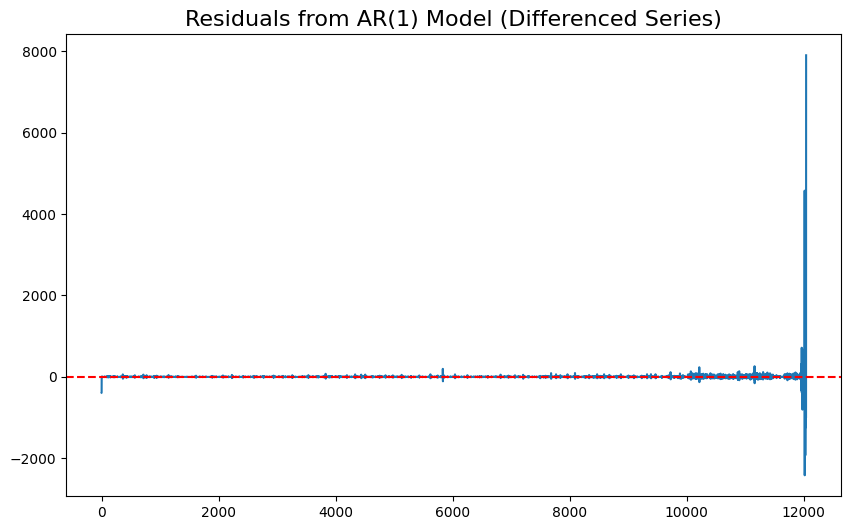

      lb_stat     lb_pvalue
1  172.837161  1.776362e-39


KeyError: -1

In [27]:
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox

# Step 3: Fit the AR(1) model to the differenced series
model_diff = AutoReg(diff_series, lags=1)
model_fitted_diff = model_diff.fit()

# Print the coefficient
print("Coefficient (phi) for the differenced series:", model_fitted_diff.params)

# Step 4: Model diagnostics - Check the residuals
residuals_diff = model_fitted_diff.resid

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals_diff)
plt.title('Residuals from AR(1) Model (Differenced Series)', fontsize=16)
plt.axhline(0, color='red', linestyle='--')
plt.show()

# Test residuals for autocorrelation
ljung_box_result_diff = acorr_ljungbox(residuals_diff, lags=[1], return_df=True)
print(ljung_box_result_diff)

# Step 5: Forecast future values in the differenced form
n_forecasts = 1  # Example: Forecast the next time interval
forecasts_diff = model_fitted_diff.predict(start=len(diff_series), end=len(diff_series) + n_forecasts - 1, dynamic=True)

# To interpret these forecasts in the context of the original series:
# 1. Start with the last known value of the original series.
# 2. Add the forecasted difference to this value.
last_known_value = time_between_commits[-1]
forecasted_value = last_known_value + forecasts_diff[0]
print("Forecasted difference for the next time interval:", forecasts_diff[0])
print("Forecasted time interval between the next commit:", forecasted_value)


In [68]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Step 1: Simulate dataset
np.random.seed(42)  # For reproducibility
dates = pd.date_range(start='2016-01-01', periods=60, freq='M')  # 5 years of monthly data
health_scores = np.abs(np.random.normal(loc=0.6, scale=0.1, size=len(dates)))  # Simulated health scores

# Ensure the date column is the index
df.set_index('date', inplace=True)

# Step 2: Prepare and Analyze the Data
# Checking for stationarity with the Augmented Dickey-Fuller test
adf_result = adfuller(df['time_between_commits'])

# Display ADF test results
adf_result


(20.389909908186308,
 1.0,
 40,
 12003,
 {'1%': -3.430894922022415,
  '5%': -2.861780827545036,
  '10%': -2.5668981874552053},
 124423.73112558664)

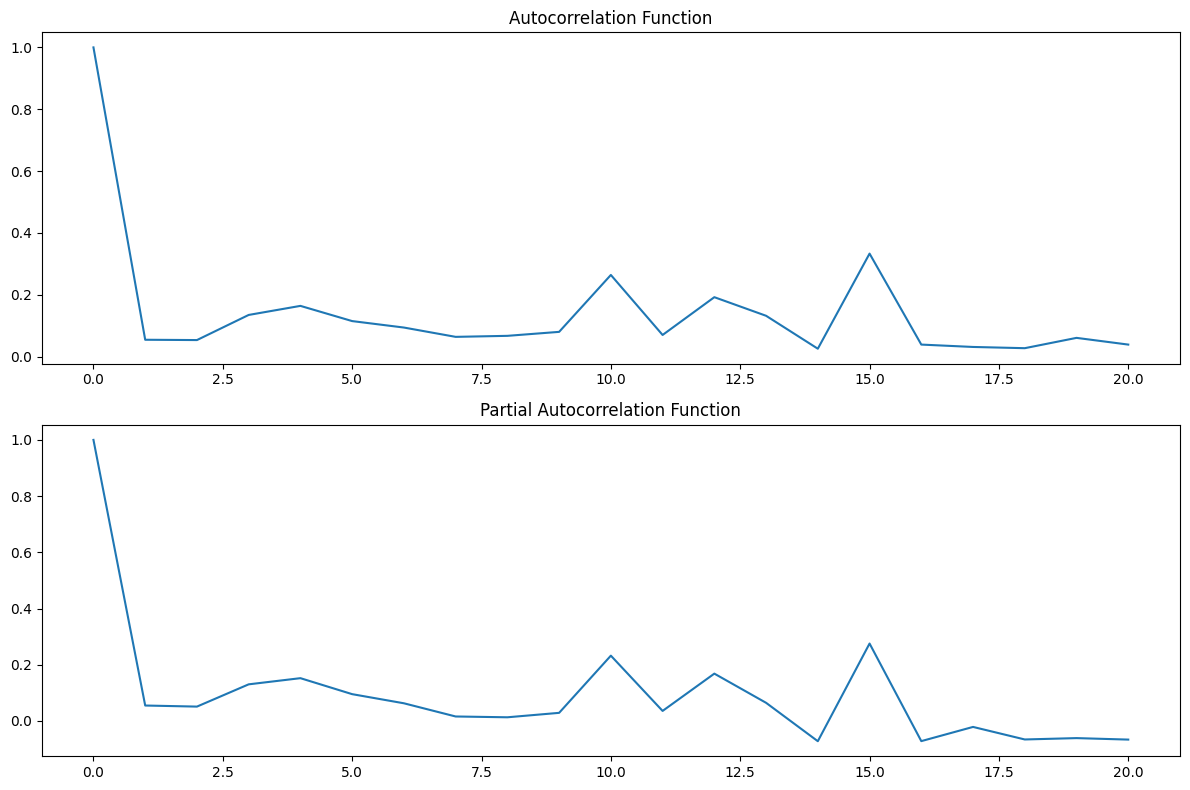

In [69]:
# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ACF
acf_plot = acf(df['time_between_commits'], nlags=20, fft=True)
ax1.plot(acf_plot)
ax1.set_title('Autocorrelation Function')

# PACF
pacf_plot = pacf(df['time_between_commits'], nlags=20, method='ywm')
ax2.plot(pacf_plot)
ax2.set_title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()


C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. fore

C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


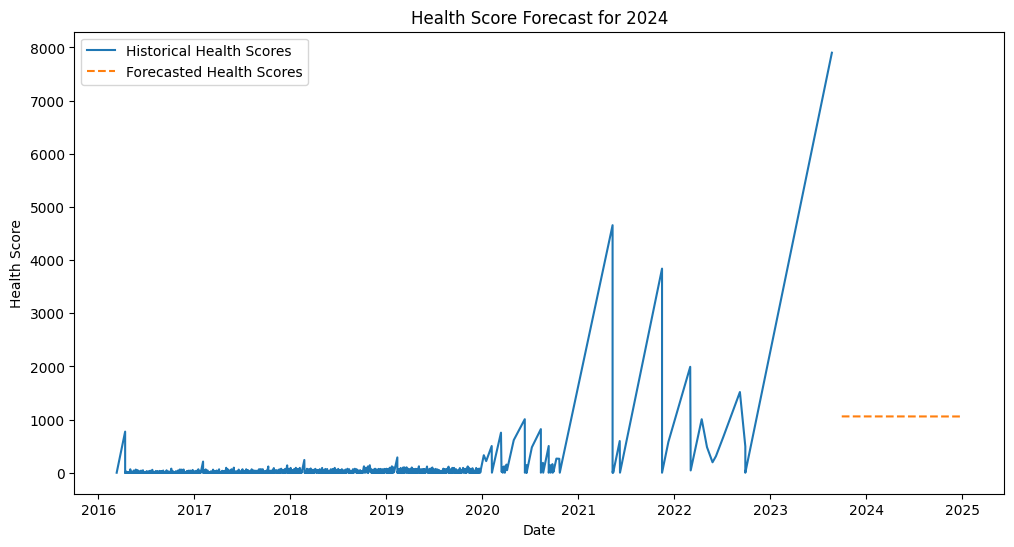

2023-09-30    1059.335357
2023-10-31    1059.249872
2023-11-30    1059.164393
2023-12-31    1059.078922
2024-01-31    1058.993457
2024-02-29    1058.907999
2024-03-31    1058.822549
2024-04-30    1058.737105
2024-05-31    1058.651668
2024-06-30    1058.566238
2024-07-31    1058.480815
2024-08-31    1058.395399
2024-09-30    1058.309990
2024-10-31    1058.224588
2024-11-30    1058.139193
2024-12-31    1058.053805
Freq: M, dtype: float64

In [70]:
model = ARIMA(df['time_between_commits'], order=(1, 0, 1))
model_fit = model.fit()

# Adjust the forecast period to start from September 2023 to December 2024
# Since our simulated data ended in January 2021, we'll calculate the number of steps to forecast from February 2021 to December 2024
forecast_start_date = '2023-09-01'
forecast_end_date = '2024-12-31'

# Calculate the number of months between the last data point and December 2024
last_data_point_date = pd.to_datetime('2023-08-31')  # Simulating as the last commit date
forecast_end_date = pd.to_datetime(forecast_end_date)

months_to_forecast = (forecast_end_date.year - last_data_point_date.year) * 12 + forecast_end_date.month - last_data_point_date.month

# Forecast the health scores from September 2023 to December 2024
forecast = model_fit.forecast(steps=months_to_forecast)

# Generate dates for the forecast period
forecast_dates = pd.date_range(start=last_data_point_date + pd.offsets.MonthBegin(1), periods=months_to_forecast, freq='M')

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['time_between_commits'], label='Historical Health Scores')
plt.plot(forecast_dates, forecast, label='Forecasted Health Scores', linestyle='--')
plt.title('Health Score Forecast for 2024')
plt.xlabel('Date')
plt.ylabel('Health Score')
plt.legend()
plt.show()

# Display the forecasted values for 2024
forecast_2024 = pd.Series(forecast.values, index=forecast_dates)
forecast_2024


In [88]:
import pandas as pd
import statsmodels.api as sm

# Assuming 'df' is your DataFrame and it has been loaded correctly
time_series = df['time_between_commits']

# Fit an AR(1) model
model = sm.tsa.ARIMA(time_series, order=(1, 0, 0))  # (1, 0, 0) indicates an AR(1) model
results = model.fit()

# Print the summary of the model to inspect the fit
print(results.summary())

# Forecast the next time interval
forecast = results.forecast(steps=1)
print(f"Predicted next time interval between commits: {forecast[0]}")


C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. fore

                                SARIMAX Results                                 
Dep. Variable:     time_between_commits   No. Observations:                12044
Model:                   ARIMA(1, 0, 0)   Log Likelihood              -72151.885
Date:                  Tue, 13 Feb 2024   AIC                         144309.770
Time:                          00:43:07   BIC                         144331.959
Sample:                               0   HQIC                        144317.212
                                - 12044                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4222      2.981      1.819      0.069      -0.421      11.265
ar.L1          0.1216      0.003     42.119      0.000       0.116       0.127
sigma2      9354.2578      7.431   1

C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


KeyError: 0

C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. fore

TypeError: _generate_range() got an unexpected keyword argument 'closed'

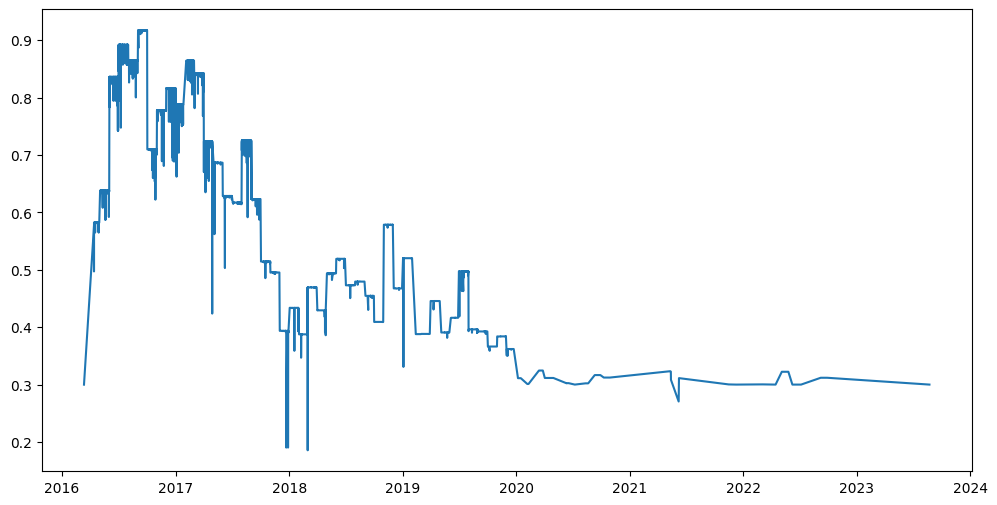

In [59]:
# Step 4: Train the ARIMA Model
model = ARIMA(df['health_score'], order=(1, 0, 1))
model_fit = model.fit()

# Step 5: Forecast Future Values
# Forecast the next 12 months
forecast = model_fit.forecast(steps=12)

# Plot the historical data and forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['health_score'], label='Historical Health Scores')
plt.plot(pd.date_range(df.index[-1], periods=13, closed='right'), forecast, label='Forecasted Health Scores', linestyle='--')
plt.title('Health Score Forecast')
plt.xlabel('Date')
plt.ylabel('Health Score')
plt.legend()
plt.show()

forecast


In [ ]:
# Adjust the forecast period to start from September 2023 to December 2024
# Since our simulated data ended in January 2021, we'll calculate the number of steps to forecast from February 2021 to December 2024
forecast_start_date = '2023-09-01'
forecast_end_date = '2024-12-31'

# Calculate the number of months between the last data point and December 2024
last_data_point_date = pd.to_datetime('2023-08-31')  # Simulating as the last commit date
forecast_end_date = pd.to_datetime(forecast_end_date)

months_to_forecast = (forecast_end_date.year - last_data_point_date.year) * 12 + forecast_end_date.month - last_data_point_date.month

# Forecast the health scores from September 2023 to December 2024
forecast = model_fit.forecast(steps=months_to_forecast)

# Generate dates for the forecast period
forecast_dates = pd.date_range(start=last_data_point_date + pd.offsets.MonthBegin(1), periods=months_to_forecast, freq='M')

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['health_score'], label='Historical Health Scores')
plt.plot(forecast_dates, forecast, label='Forecasted Health Scores', linestyle='--')
plt.title('Health Score Forecast for 2024')
plt.xlabel('Date')
plt.ylabel('Health Score')
plt.legend()
plt.show()

# Display the forecasted values for 2024
forecast_2024 = pd.Series(forecast.values, index=forecast_dates)
forecast_2024


C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  self._init_dates(dates, freq)
C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  self._init_dates(dates, freq)
C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           health_score   No. Observations:                12044
Model:                 ARIMA(1, 1, 1)   Log Likelihood               36134.917
Date:                Tue, 06 Feb 2024   AIC                         -72263.833
Time:                        13:50:21   BIC                         -72241.644
Sample:                    01-01-1970   HQIC                        -72256.391
                         - 01-01-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0159      0.004      3.543      0.000       0.007       0.025
ma.L1         -0.5952      0.004   -142.120      0.000      -0.603      -0.587
sigma2         0.0001   2.27e-07    638.995      0.0

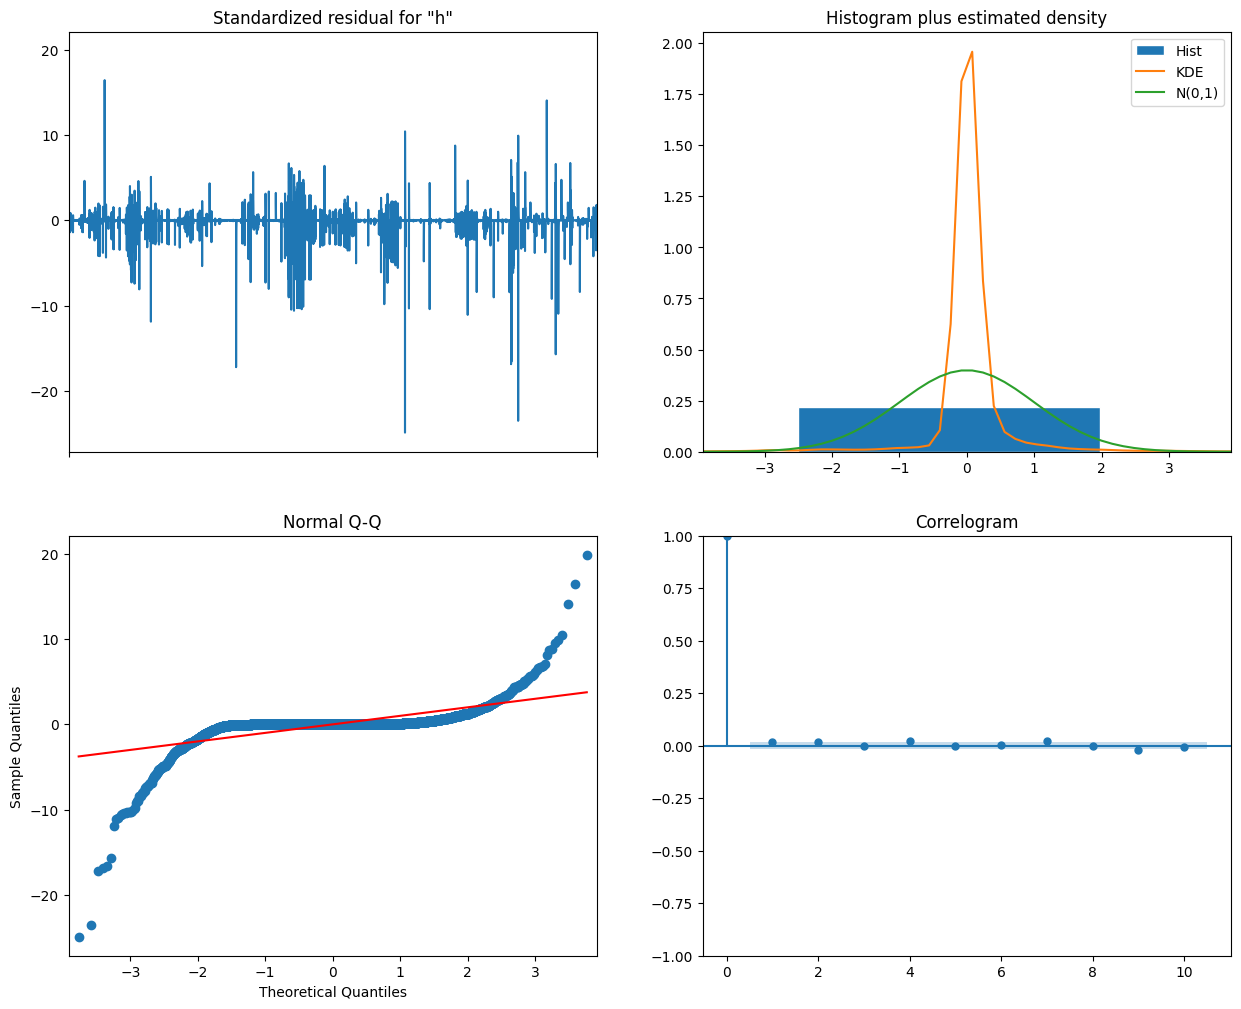

1970-01-01 00:00:00.000012044    0.306478
1970-01-01 00:00:00.000012045    0.306581
1970-01-01 00:00:00.000012046    0.306582
1970-01-01 00:00:00.000012047    0.306582
1970-01-01 00:00:00.000012048    0.306582
Freq: N, Name: predicted_mean, dtype: float64


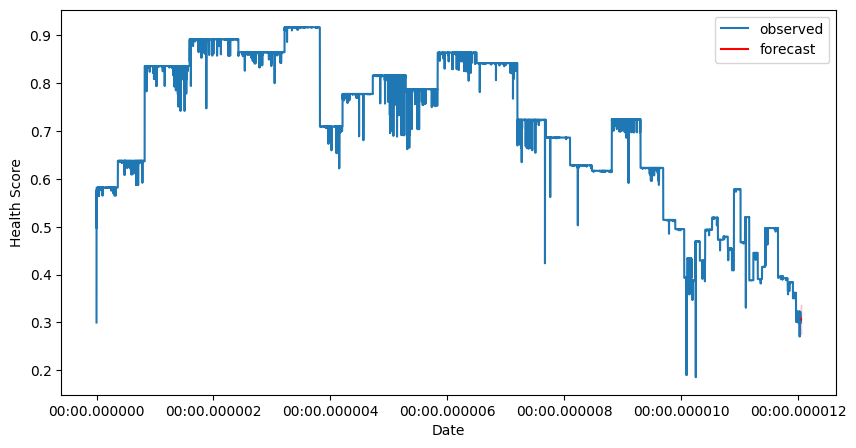

In [26]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt


# Fit the ARIMA model
# The order (p,d,q) needs to be determined using model diagnostics.
# We will assume (1,1,1) for the sake of this example.
model = ARIMA(repo['health_score'], order=(1,1,1))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Plot diagnostics
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

# Forecasting the next 5 periods (adjust as needed)
forecast = model_fit.get_forecast(steps=5)
predicted_health_scores = forecast.predicted_mean
conf_int = forecast.conf_int()

# Print the forecasted health scores
print(predicted_health_scores)

# Plot the data and the forecast with confidence intervals
plt.figure(figsize=(10,5))
plt.plot(repo.index, repo['health_score'], label='observed')
plt.plot(predicted_health_scores.index, predicted_health_scores, color='r', label='forecast')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink')
plt.xlabel('Date')
plt.ylabel('Health Score')
plt.legend()
plt.show()


In [25]:
repo.date = pd.to_datetime(repo.date)

In [19]:
repo.head()


,month,url,repo,author,date,totalAdditions,totalDeletions,net_code_change,message,numFiles,...,monthly_commits,monthly_unique_authors,monthly_additions,monthly_deletions,time_between_commits,normalized_activity_level,normalized_community_involvement,normalized_stability,health_score,health_score_diff
0,2016-03,https://api.github.com/repos/alibaba/weex/comm...,weex,lvscar,2016-03-11 10:18:12+00:00,203,0,203,Initial commit,2,...,1,1,203,0,0.000000,0.000000,0.000000,0.999598,0.299879,NaN
1,2016-04,https://api.github.com/repos/alibaba/weex/comm...,weex,luics,2016-04-12 15:21:18+00:00,617,8351,-7734,+ [all] init,1046,...,364,15,434399,88352,773.051667,0.435774,0.378378,0.982223,0.576751,0.276871
2,2016-04,https://api.github.com/repos/alibaba/weex/comm...,weex,luics,2016-04-12 15:21:18+00:00,142902,5,142897,+ [all] init,1054,...,364,15,434399,88352,0.000000,0.435774,0.378378,0.716724,0.497101,-0.079650
3,2016-04,https://api.github.com/repos/alibaba/weex/comm...,weex,luics,2016-04-12 15:22:31+00:00,30,6,24,+ [doc] contributing doc,2,...,364,15,434399,88352,0.020278,0.435774,0.378378,0.999929,0.582062,0.084962
4,2016-04,https://api.github.com/repos/alibaba/weex/comm...,weex,luics,2016-04-12 16:00:06+00:00,32,16,16,* [doc] commit & branch format,2,...,364,15,434399,88352,0.626389,0.435774,0.378378,0.999905,0.582055,-0.000007


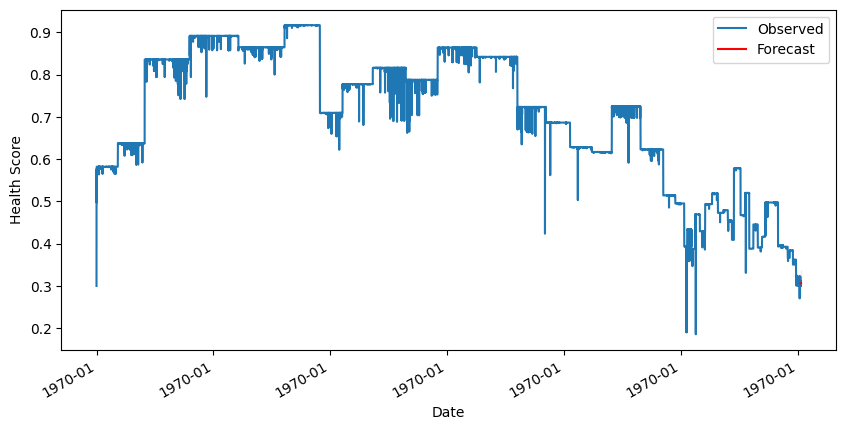

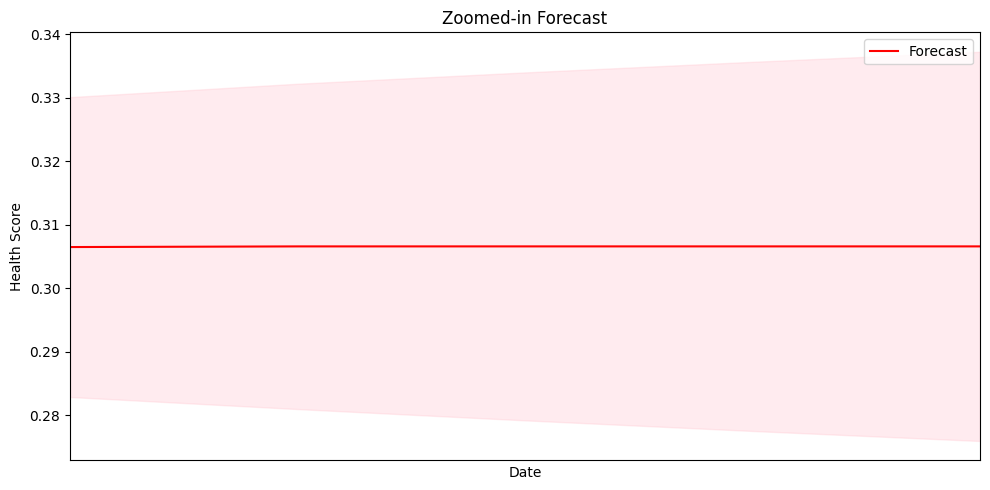

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter

# Convert string dates to datetime objects if necessary
repo.index = pd.to_datetime(repo.index)
predicted_health_scores.index = pd.to_datetime(predicted_health_scores.index)
conf_int.index = pd.to_datetime(conf_int.index)

# Plot the data and the forecast with confidence intervals
plt.figure(figsize=(10,5))
plt.plot(repo.index, repo['health_score'], label='Observed')
plt.plot(predicted_health_scores.index, predicted_health_scores, color='r', label='Forecast')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

# Set the date format on the x-axis
date_form = DateFormatter("%Y-%m")
plt.gca().xaxis.set_major_formatter(date_form)

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

plt.xlabel('Date')
plt.ylabel('Health Score')
plt.legend()
plt.show()

# Zoomed-in version of the forecasted part
plt.figure(figsize=(10,5))
plt.plot(predicted_health_scores.index, predicted_health_scores, color='r', label='Forecast')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

# Assuming that 'predicted_health_scores' starts with the forecast period
plt.xlim(predicted_health_scores.index[0], predicted_health_scores.index[-1])

# Set the date format on the x-axis
plt.gca().xaxis.set_major_formatter(date_form)

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

plt.xlabel('Date')
plt.ylabel('Health Score')
plt.title('Zoomed-in Forecast')
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [28]:
repo.head()

,url,repo,author,date,totalAdditions,totalDeletions,net_code_change,message,numFiles,numComments,fileTuple
11328,https://api.github.com/repos/google/WebFundame...,WebFundamentals,PaulKinlan,2014-03-06T15:42:44Z,314,0,314,First commit of new site,8,0,"[('.gitignore', 'added', 1, 0, 1, 'https://git..."
11327,https://api.github.com/repos/google/WebFundame...,WebFundamentals,PaulKinlan,2014-03-21T14:32:16Z,15281,313,14968,Adding a port of dartlang infrastrcuture,110,0,"[('_config.yml', 'removed', 0, 3, 3, 'https://..."
11326,https://api.github.com/repos/google/WebFundame...,WebFundamentals,PaulKinlan,2014-03-21T14:41:44Z,32,10,22,Adding a make file,3,0,"[('.gitignore', 'modified', 1, 1, 2, 'https://..."
11325,https://api.github.com/repos/google/WebFundame...,WebFundamentals,PaulKinlan,2014-03-21T15:08:54Z,97,107,-10,Adding more stuff and checking build process,9,0,"[('src/site/_includes/author.html', 'removed',..."
11324,https://api.github.com/repos/google/WebFundame...,WebFundamentals,PaulKinlan,2014-03-21T19:08:06Z,208,88,120,Adding articles as samples. Updating the arti...,15,0,"[('src/site/_plugins/articles_tag.rb', 'modifi..."


In [29]:
commit_data = repo

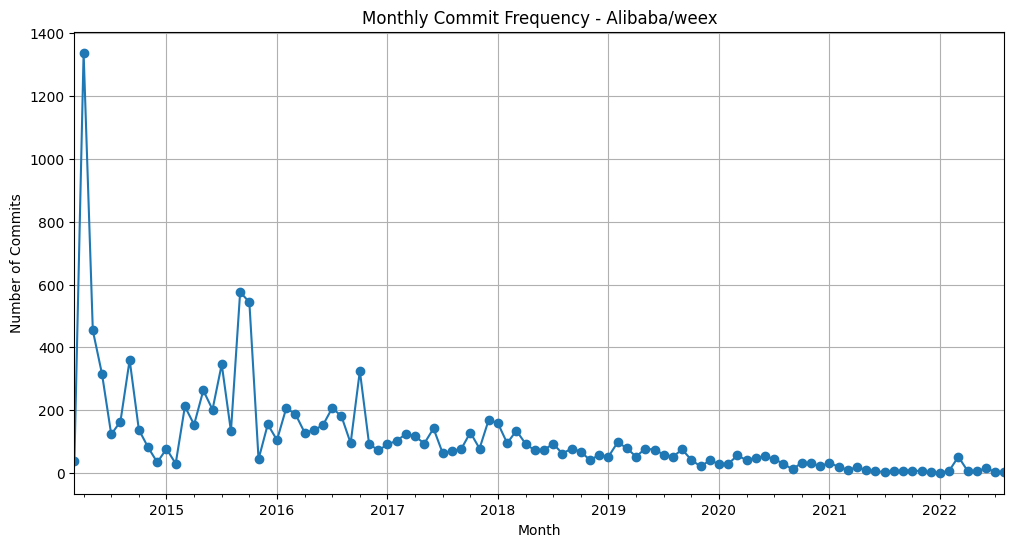

date
2022-04-30 00:00:00+00:00     7
2022-05-31 00:00:00+00:00     5
2022-06-30 00:00:00+00:00    16
2022-07-31 00:00:00+00:00     3
2022-08-31 00:00:00+00:00     2
Freq: M, dtype: int64

In [30]:
import matplotlib.pyplot as plt

# Convert 'date' column to datetime
repo['date'] = pd.to_datetime(repo['date'])

# Resample by month and count the number of commits
monthly_commits = repo.resample('M', on='date').size()

# Plotting the data
plt.figure(figsize=(12, 6))
monthly_commits.plot(kind='line', marker='o')
plt.title('Monthly Commit Frequency - Alibaba/weex')
plt.xlabel('Month')
plt.ylabel('Number of Commits')
plt.grid(True)
plt.show()

monthly_commits.tail()


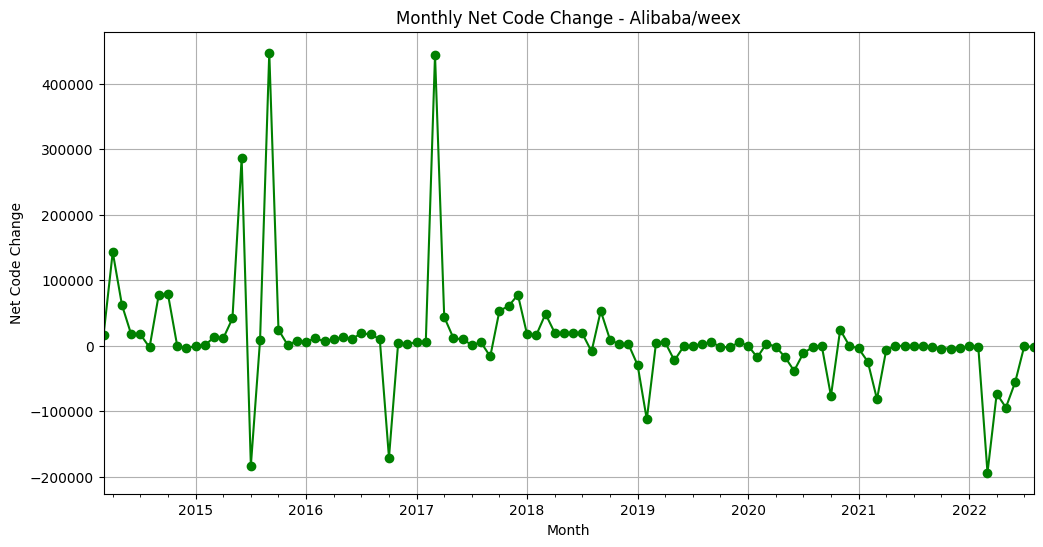

date
2022-04-30 00:00:00+00:00   -73064
2022-05-31 00:00:00+00:00   -94135
2022-06-30 00:00:00+00:00   -55769
2022-07-31 00:00:00+00:00     -192
2022-08-31 00:00:00+00:00    -2072
Freq: M, Name: net_code_change, dtype: int64

In [31]:
import matplotlib.pyplot as plt

# Resample by month and sum the total additions
monthly_additions = repo.resample('M', on='date')['net_code_change'].sum()

# Plotting the data
plt.figure(figsize=(12, 6))
monthly_additions.plot(kind='line', marker='o', color='green')
plt.title('Monthly Net Code Change - Alibaba/weex')
plt.xlabel('Month')
plt.ylabel('Net Code Change')
plt.grid(True)
plt.show()

monthly_additions.tail()


##### author contribution

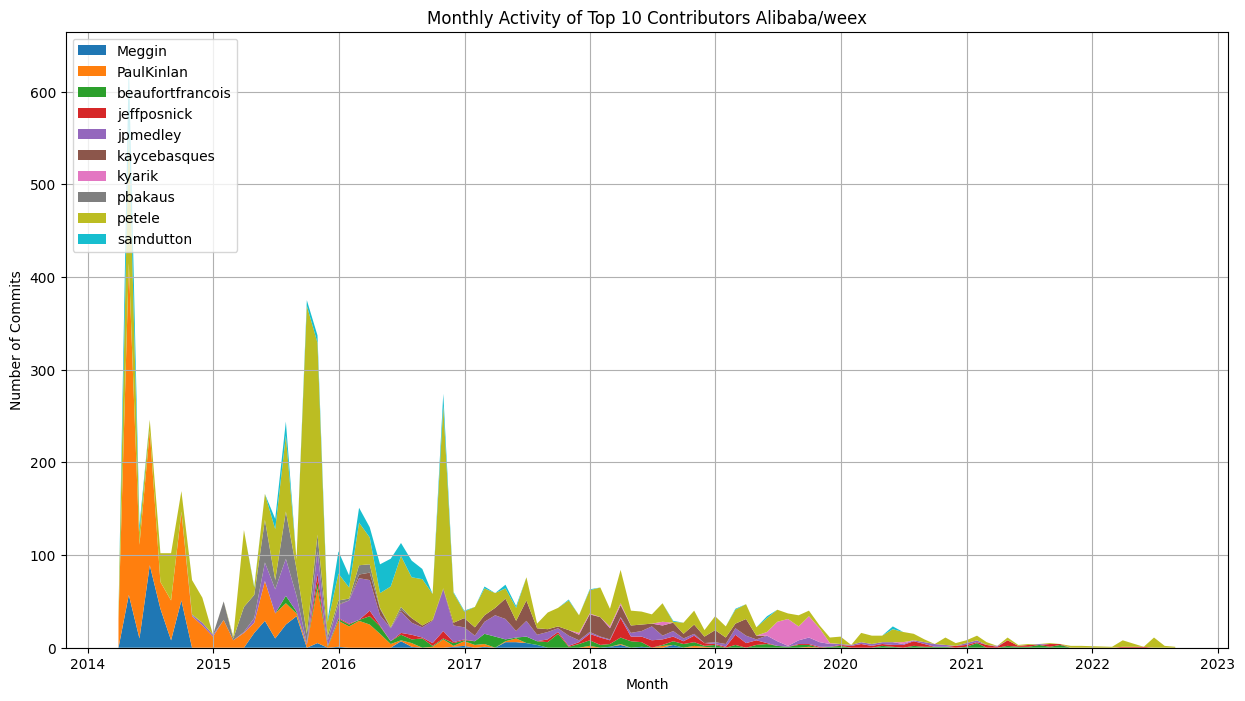

author,Meggin,PaulKinlan,beaufortfrancois,jeffposnick,jpmedley,kaycebasques,kyarik,pbakaus,petele,samdutton
date,,,,,,,,,,
2022-03-31 00:00:00+00:00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,0.0
2022-05-31 00:00:00+00:00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-30 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0
2022-07-31 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
2022-08-31 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [32]:
import matplotlib.pyplot as plt

# Identifying the top ten authors by total number of commits
top_authors = repo['author'].value_counts().nlargest(10).index

# Filtering the data to include only commits from these top authors
top_authors_data = repo[repo['author'].isin(top_authors)]

# Grouping data by author and resampling by month
top_authors_monthly_commits = top_authors_data.groupby(['author', pd.Grouper(freq='M', key='date')]).size().reset_index(name='num_commits')

# Pivoting the table for visualization
top_pivot_table = top_authors_monthly_commits.pivot(index='date', columns='author', values='num_commits').fillna(0)

# Plotting the data
plt.figure(figsize=(15, 8))
plt.stackplot(top_pivot_table.index, top_pivot_table.values.T, labels=top_pivot_table.columns)
plt.title('Monthly Activity of Top 10 Contributors Alibaba/weex')
plt.xlabel('Month')
plt.ylabel('Number of Commits')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

top_pivot_table.tail()


#### commit Time difference 

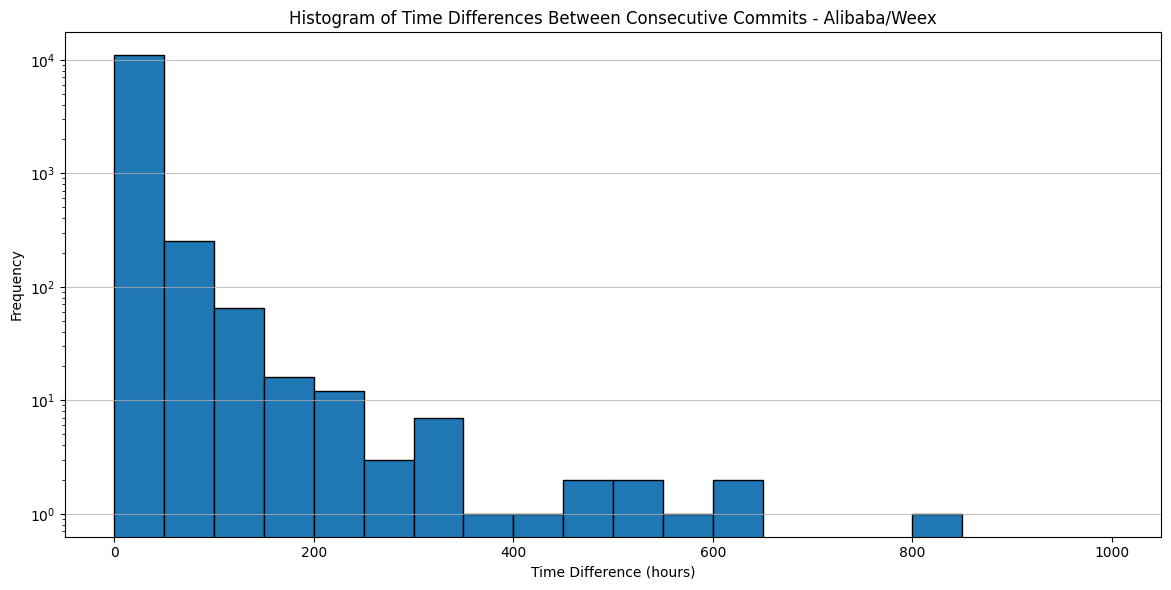

In [33]:
repo['time_diff'] = repo['date'].diff()
repo['time_diff'] = repo['time_diff'].fillna(pd.to_timedelta(0))
repo['time_diff_hours'] = repo['time_diff'].dt.total_seconds() / 3600

# Plotting histogram
plt.figure(figsize=(12, 6))
plt.hist(repo['time_diff_hours'], bins=20, edgecolor='black', range=(0, 1000))  
plt.title('Histogram of Time Differences Between Consecutive Commits - Alibaba/Weex')
plt.xlabel('Time Difference (hours)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()

plt.yscale('log')

plt.show()

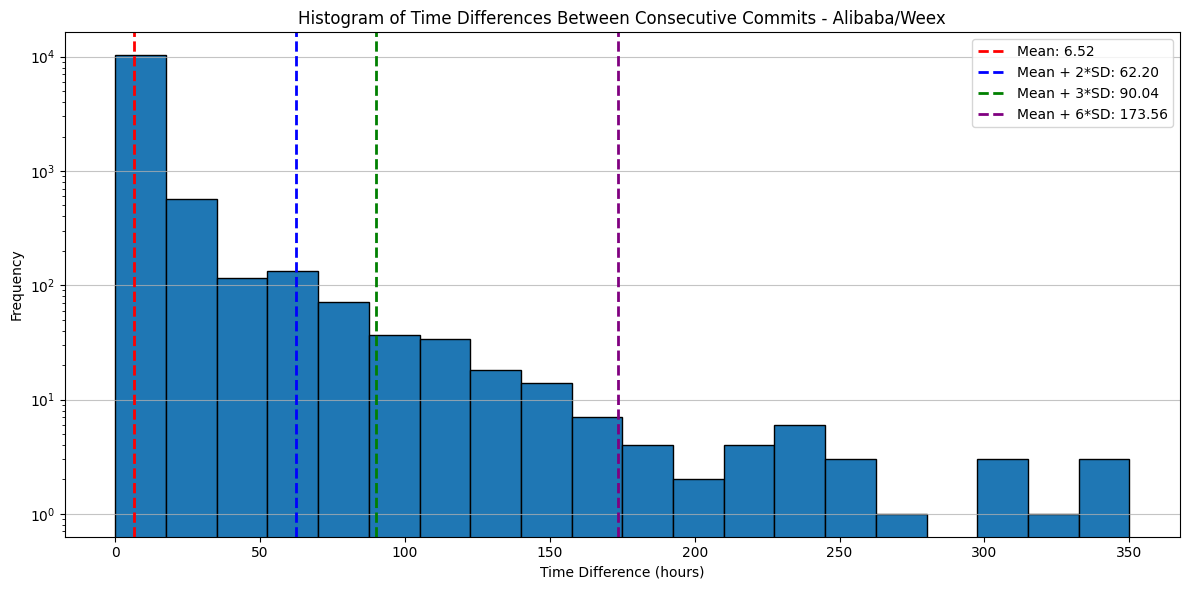

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'repo' is your DataFrame with commit information
repo['time_diff'] = repo['date'].diff()
repo['time_diff'] = repo['time_diff'].fillna(pd.to_timedelta(0))
repo['time_diff_hours'] = repo['time_diff'].dt.total_seconds() / 3600

# Plotting histogram
plt.figure(figsize=(12, 6))
plt.hist(repo['time_diff_hours'], bins=20, edgecolor='black', range=(0, 350))  
plt.title('Histogram of Time Differences Between Consecutive Commits - Alibaba/Weex')
plt.xlabel('Time Difference (hours)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Log-scale y-axis
plt.yscale('log')

# Add mean line
mean_value = repo['time_diff_hours'].mean()
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')

# Add second standard deviation (SD) line
std_value = repo['time_diff_hours'].std()
second_sd_line = mean_value + 2 * std_value
plt.axvline(second_sd_line, color='blue', linestyle='dashed', linewidth=2, label=f'Mean + 2*SD: {second_sd_line:.2f}')

# Add third standard deviation (SD) line
second_sd_line = mean_value + 3 * std_value
plt.axvline(second_sd_line, color='green', linestyle='dashed', linewidth=2, label=f'Mean + 3*SD: {second_sd_line:.2f}')


# Add third standard deviation (SD) line
second_sd_line = mean_value + 6 * std_value
plt.axvline(second_sd_line, color='purple', linestyle='dashed', linewidth=2, label=f'Mean + 6*SD: {second_sd_line:.2f}')

plt.legend()  # Show legend

plt.tight_layout()
plt.show()


In [47]:
repo

,url,repo,author,totalAdditions,totalDeletions,net_code_change,message,numFiles,numComments,fileTuple,time_diff,time_diff_hours,code_churn
date,,,,,,,,,,,,,
2016-03-11 10:18:12+00:00,https://api.github.com/repos/alibaba/weex/comm...,weex,lvscar,203,0,203,Initial commit,2,0,"[(LICENSE, added, 201, 0, 201, https://github....",NaT,0.000000,203
2016-04-12 15:21:18+00:00,https://api.github.com/repos/alibaba/weex/comm...,weex,luics,617,8351,-7734,+ [all] init,1046,0,"[(CONTRIBUTING.md, modified, 0, 0, 0, https://...",32 days 05:03:06,773.051667,8968
2016-04-12 15:21:18+00:00,https://api.github.com/repos/alibaba/weex/comm...,weex,luics,142902,5,142897,+ [all] init,1054,1,"[(.gitignore, added, 23, 0, 23, https://github...",0 days 00:00:00,0.000000,142907
2016-04-12 15:22:31+00:00,https://api.github.com/repos/alibaba/weex/comm...,weex,luics,30,6,24,+ [doc] contributing doc,2,0,"[(CONTRIBUTING.md, added, 28, 0, 28, https://g...",0 days 00:01:13,0.020278,36
2016-04-12 16:00:06+00:00,https://api.github.com/repos/alibaba/weex/comm...,weex,luics,32,16,16,* [doc] commit & branch format,2,0,"[(CONTRIBUTING.md, modified, 31, 11, 42, https...",0 days 00:37:35,0.626389,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-07 13:19:18+00:00,https://api.github.com/repos/alibaba/weex/comm...,weex,katherine95s,2,1,1,fix:修复OnReceivedResult CallbackId (#3313) * [...,1,0,[(weex_core/Source/android/bridge/script_bridg...,63 days 06:04:41,1518.078056,3
2022-09-28 03:42:59+00:00,https://api.github.com/repos/alibaba/weex/comm...,weex,yuditxj,8,0,8,[ios]fix maxlength issues (#3312),1,0,[(ios/sdk/WeexSDK/Sources/Component/WXEditComp...,20 days 14:23:41,494.394722,8
2022-09-28 03:44:41+00:00,https://api.github.com/repos/alibaba/weex/comm...,weex,yuditxj,2,0,2,[ios]fix date|time reset issues (#3311),1,0,[(ios/sdk/WeexSDK/Sources/Component/WXEditComp...,0 days 00:01:42,0.028333,2


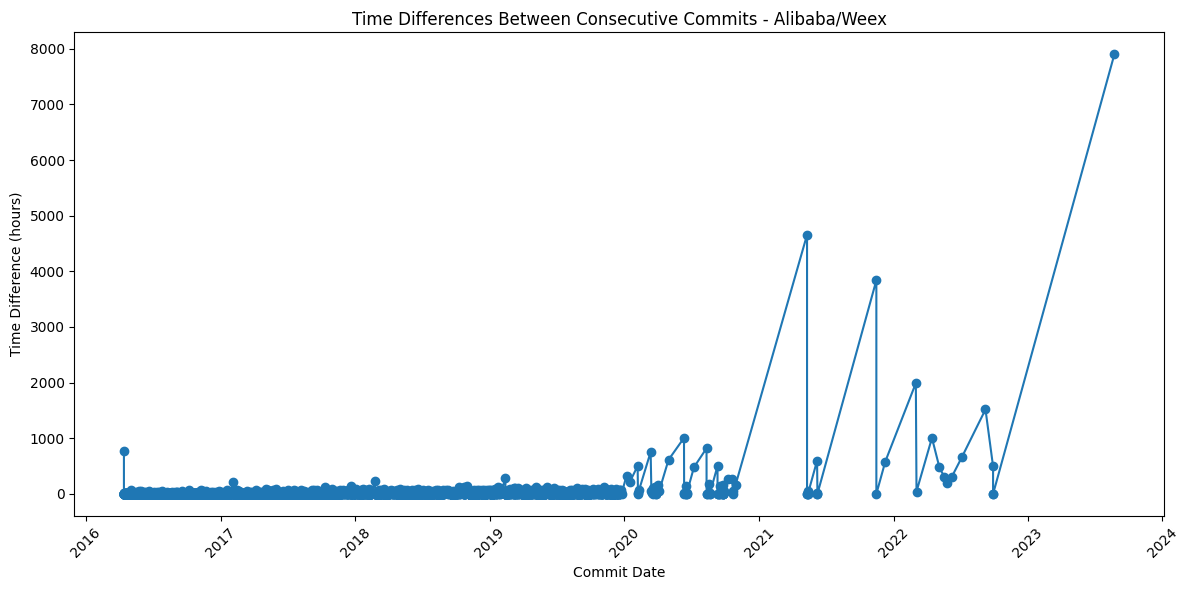

In [17]:
import pandas as pd
import matplotlib.pyplot as plt



# Calculate time differences between consecutive commits
repo['time_diff'] = repo['date'].diff()

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'commit_date': repo['date'],
    'time_diff': repo['time_diff']
})

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(plot_data['commit_date'], plot_data['time_diff'].dt.total_seconds() / 3600, marker='o', linestyle='-')
plt.title('Time Differences Between Consecutive Commits - Alibaba/Weex')
plt.xlabel('Commit Date')
plt.ylabel('Time Difference (hours)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\ethan\AppData\Local\Temp\ipykernel_32512\1343960593.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_repo['time_diff'] = filtered_repo['date'].diff()


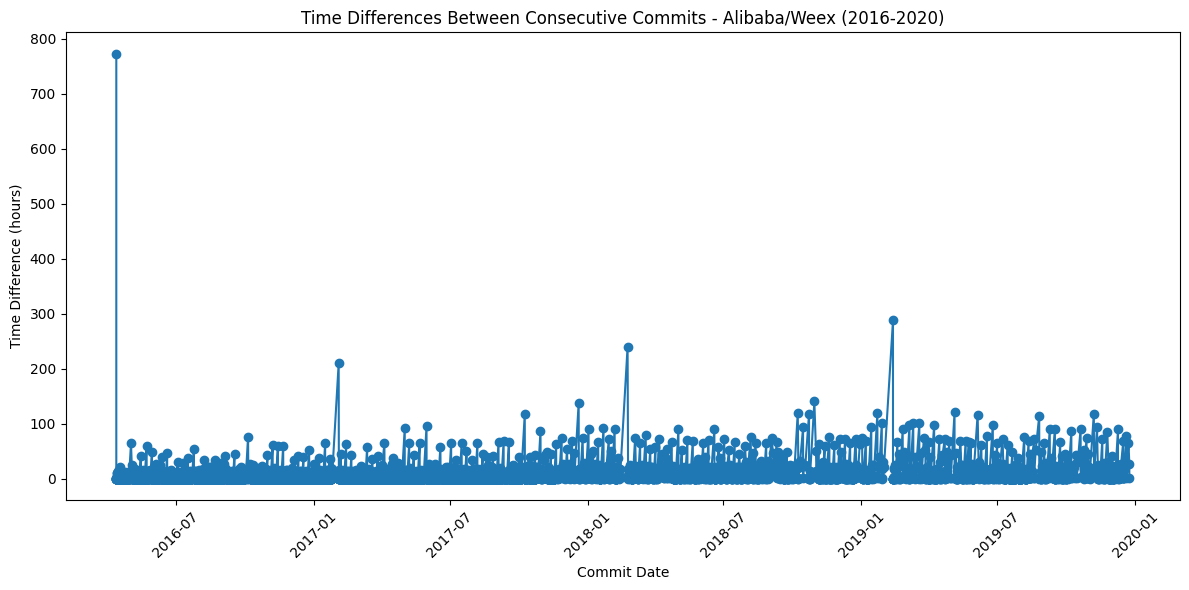

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming repo is your DataFrame

# Filter commits between 2016 and 2020
filtered_repo = repo[(repo['date'] >= '2016-01-01') & (repo['date'] <= '2020-01-1')]

# Calculate time differences between consecutive commits
filtered_repo['time_diff'] = filtered_repo['date'].diff()

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'commit_date': filtered_repo['date'],
    'time_diff': filtered_repo['time_diff']
})

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(plot_data['commit_date'], plot_data['time_diff'].dt.total_seconds() / 3600, marker='o', linestyle='-')
plt.title('Time Differences Between Consecutive Commits - Alibaba/Weex (2016-2020)')
plt.xlabel('Commit Date')
plt.ylabel('Time Difference (hours)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Code latency 

In [19]:

# Calculate statistics for code review latency
average_latency = repo['time_diff_hours'].mean()
median_latency = repo['time_diff_hours'].median()
max_latency = repo['time_diff_hours'].max()

print(f"Average Code  Latency: {average_latency:.2f} hours")
print(f"Median Code  Latency: {median_latency:.2f} hours")
print(f"Maximum Code  Latency: {max_latency:.2f} hours")

Average Code  Latency: 5.42 hours
Median Code  Latency: 0.24 hours
Maximum Code  Latency: 7900.86 hours


#### Code Churn

In [33]:
repo['code_churn'] = repo['totalAdditions'] + repo['totalDeletions']


# Set the date column as the index
repo.set_index('date', inplace=True)

# Resample and sum churn over your chosen time interval, e.g., weekly
weekly_churn = repo['code_churn'].resample('W').sum()


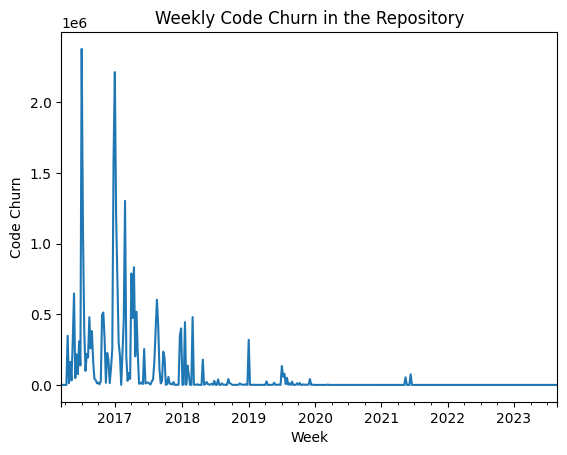

In [34]:
import matplotlib.pyplot as plt

weekly_churn.plot()
plt.title('Weekly Code Churn in the Repository')
plt.xlabel('Week')
plt.ylabel('Code Churn')
plt.show()


In [35]:
# Weekly Churn
weekly_churn = repo['code_churn'].resample('W').sum()

# Monthly Churn
monthly_churn = repo['code_churn'].resample('M').sum()

# Quarterly Churn
quarterly_churn = repo['code_churn'].resample('Q').sum()


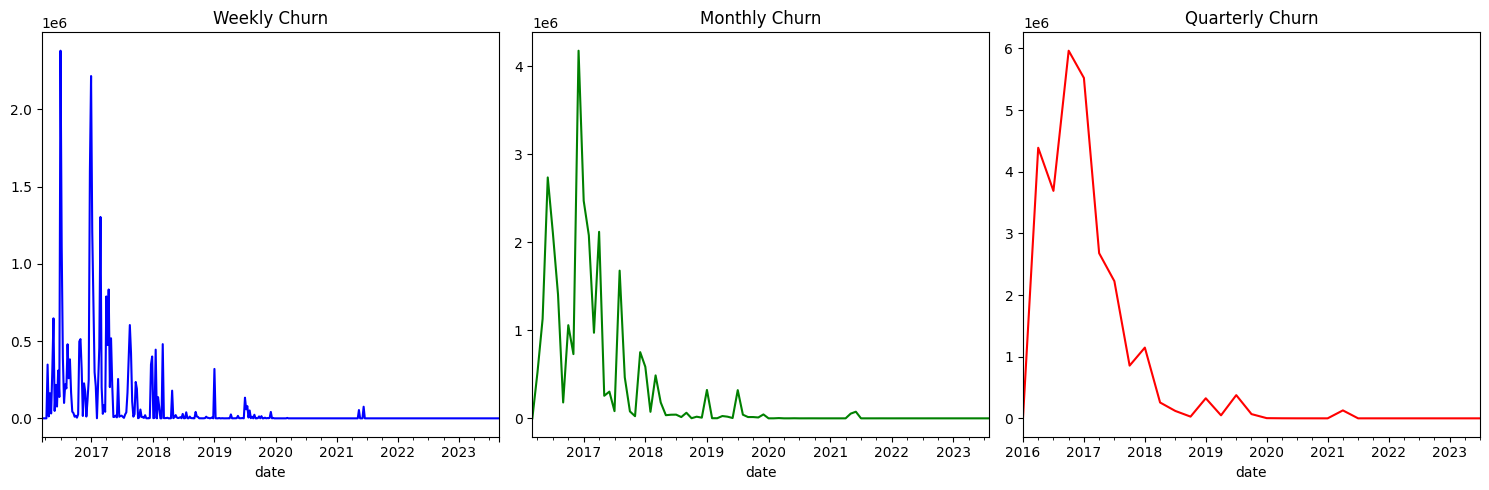

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Plotting Weekly Churn
plt.subplot(1, 3, 1)
weekly_churn.plot(title='Weekly Churn', color='blue')

# Plotting Monthly Churn
plt.subplot(1, 3, 2)
monthly_churn.plot(title='Monthly Churn', color='green')

# Plotting Quarterly Churn
plt.subplot(1, 3, 3)
quarterly_churn.plot(title='Quarterly Churn', color='red')

plt.tight_layout()
plt.show()


#### unique contributors 

In [45]:
# Count unique contributors per time period (e.g., per month)
monthly_contributors = repo.groupby(repo.index.to_period('M')).nunique()['author']

# Plotting the number of unique contributors per month
monthly_contributors.plot(kind='bar', figsize=(10, 5))
plt.title('Unique Contributors per Month')
plt.xlabel('Month')
plt.ylabel('Number of Unique Contributors')

# This ensures that the x-axis labels are dates and not too crowded.
plt.xticks(rotation=45)

plt.tight_layout() # This will help to fit the plot within the figure area properly.
plt.show()

C:\Users\ethan\AppData\Local\Temp\ipykernel_32512\3466810064.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_contributors = repo.groupby(repo.index.to_period('M')).nunique()['author']


TypeError: unhashable type: 'list'

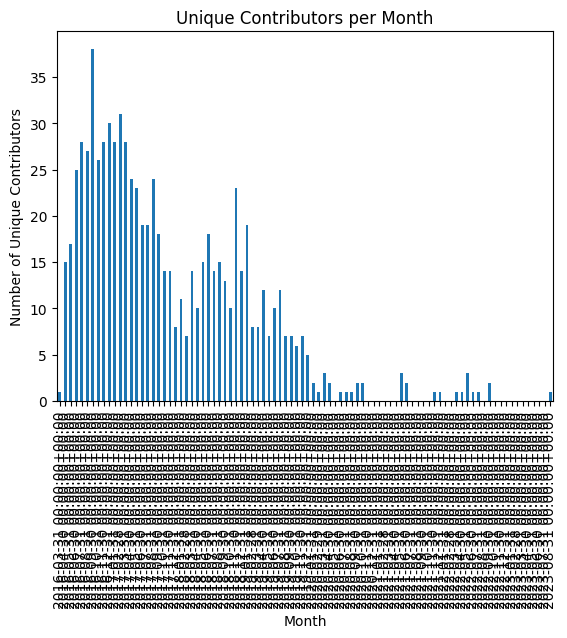

In [42]:
# Set the date as the index
#repo.set_index('date', inplace=True)

# Count unique contributors monthly
monthly_contributors = repo.groupby(pd.Grouper(freq='M'))['author'].nunique()

import matplotlib.pyplot as plt

monthly_contributors.plot(kind='bar')
plt.title('Unique Contributors per Month')
plt.xlabel('Month')
plt.ylabel('Number of Unique Contributors')
plt.show()


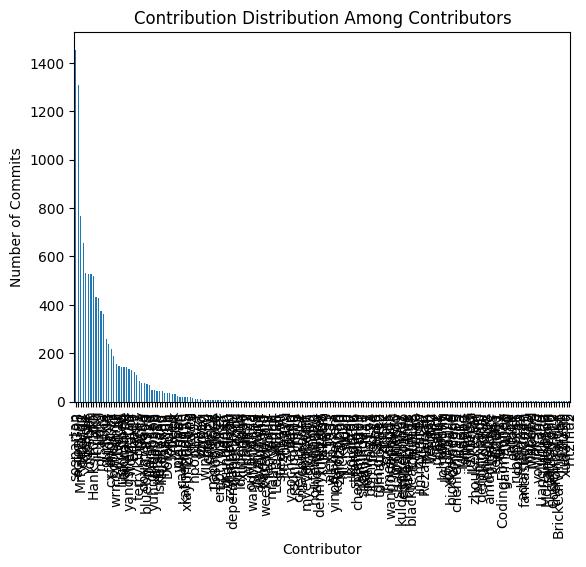

In [43]:
commit_counts = repo['author'].value_counts()
commit_counts.plot(kind='bar')
plt.title('Contribution Distribution Among Contributors')
plt.xlabel('Contributor')
plt.ylabel('Number of Commits')
plt.show()


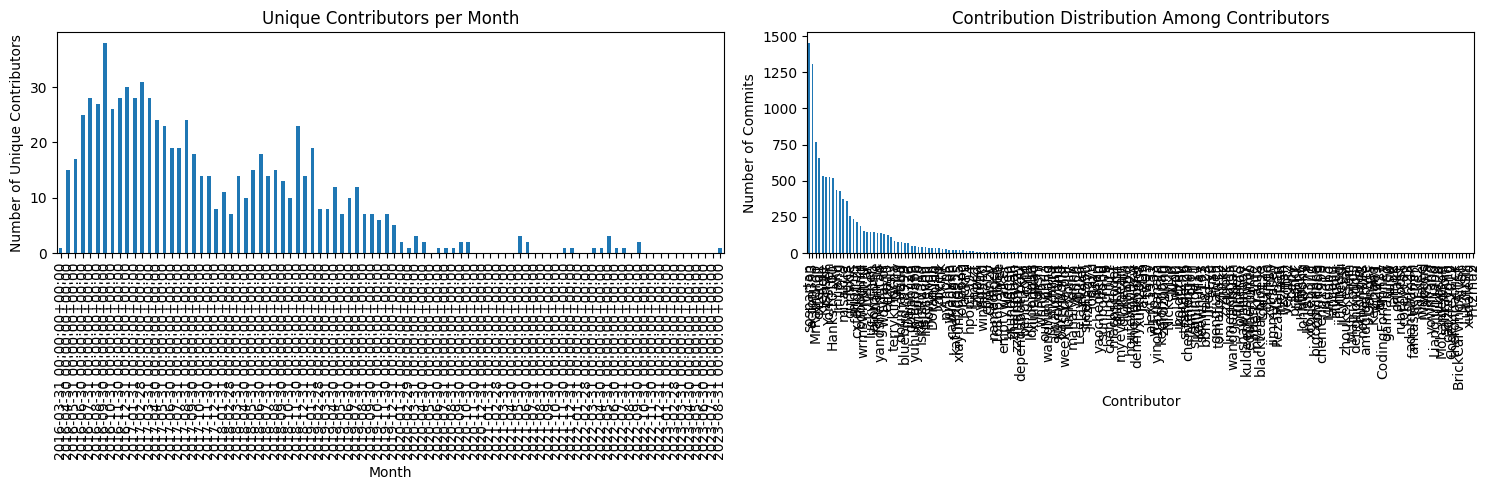

In [44]:
plt.figure(figsize=(15, 5))

# Plotting unique contributors over time
plt.subplot(1, 2, 1)
monthly_contributors.plot(kind='bar')
plt.title('Unique Contributors per Month')
plt.xlabel('Month')
plt.ylabel('Number of Unique Contributors')

# Plotting contribution distribution
plt.subplot(1, 2, 2)
commit_counts.plot(kind='bar')
plt.title('Contribution Distribution Among Contributors')
plt.xlabel('Contributor')
plt.ylabel('Number of Commits')

plt.tight_layout()
plt.show()


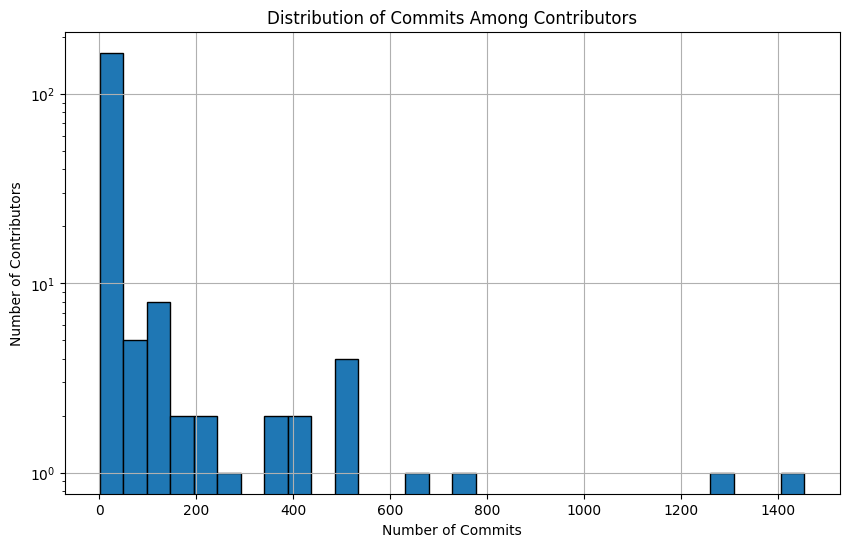

In [39]:
# Set the date as the index
repo.set_index('date', inplace=True)

# Count unique contributors monthly
monthly_contributors = repo.groupby(pd.Grouper(freq='M'))['author'].nunique()

#### time series

In [59]:
import pandas as pd



# Resample the data to a regular time interval (e.g., daily)
# Use the count of commits per day as the value to forecast
daily_commits = repo.resample('D').size()


In [60]:
from statsmodels.tsa.stattools import adfuller

# Augmented Dickey-Fuller test
result = adfuller(daily_commits.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -2.5538253163260896
p-value: 0.10292101766679645


In [88]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Fit the ARIMA model
# Experiment with different parameters (p, d, q) as needed
model = ARIMA(daily_commits, order=(2, 2, 1))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2722
Model:                 ARIMA(2, 2, 1)   Log Likelihood               -9384.339
Date:                Tue, 23 Jan 2024   AIC                          18776.678
Time:                        14:50:50   BIC                          18800.312
Sample:                    03-11-2016   HQIC                         18785.222
                         - 08-23-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1437      0.010    -15.051      0.000      -0.162      -0.125
ar.L2         -0.2614      0.009    -29.422      0.000      -0.279      -0.244
ma.L1         -1.0000      0.658     -1.519      0.1

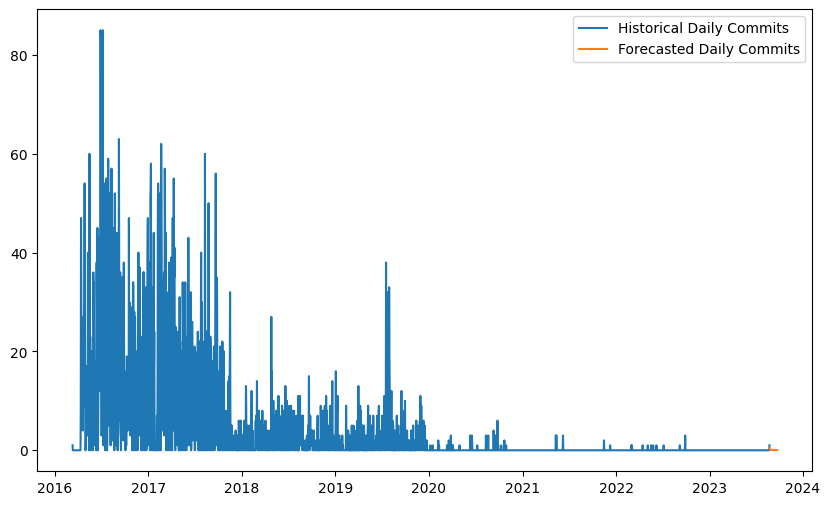

In [75]:
# Forecast the next 30 days
forecast = model_fit.forecast(steps=30)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(daily_commits, label='Historical Daily Commits')
plt.plot(forecast, label='Forecasted Daily Commits')
plt.legend()
plt.show()


In [76]:
forecast

2023-08-24 00:00:00+00:00    0.459818
2023-08-25 00:00:00+00:00    0.229814
2023-08-26 00:00:00+00:00    0.131881
2023-08-27 00:00:00+00:00    0.090182
2023-08-28 00:00:00+00:00    0.072426
2023-08-29 00:00:00+00:00    0.064867
2023-08-30 00:00:00+00:00    0.061648
2023-08-31 00:00:00+00:00    0.060277
2023-09-01 00:00:00+00:00    0.059693
2023-09-02 00:00:00+00:00    0.059445
2023-09-03 00:00:00+00:00    0.059339
2023-09-04 00:00:00+00:00    0.059294
2023-09-05 00:00:00+00:00    0.059275
2023-09-06 00:00:00+00:00    0.059267
2023-09-07 00:00:00+00:00    0.059263
2023-09-08 00:00:00+00:00    0.059262
2023-09-09 00:00:00+00:00    0.059261
2023-09-10 00:00:00+00:00    0.059261
2023-09-11 00:00:00+00:00    0.059261
2023-09-12 00:00:00+00:00    0.059261
2023-09-13 00:00:00+00:00    0.059261
2023-09-14 00:00:00+00:00    0.059261
2023-09-15 00:00:00+00:00    0.059261
2023-09-16 00:00:00+00:00    0.059261
2023-09-17 00:00:00+00:00    0.059261
2023-09-18 00:00:00+00:00    0.059261
2023-09-19 0

#### FileTuple

In [20]:
import pandas as pd

# Convert the 'fileTuple' column from a list to a string
repo['fileTuple'] = repo['fileTuple'].apply(str)

# Parse the 'fileTuple' column to extract file information using ast.literal_eval
import ast
repo['fileTuple'] = repo['fileTuple'].apply(ast.literal_eval)

# Create a new DataFrame to store file-level information
file_df = pd.DataFrame()

# Iterate through each row of the original DataFrame
for index, row in repo.iterrows():
    commit_files = row['fileTuple']
    for file_info in commit_files:
        file_dict = {
            'url': row['url'],
            'file_name': file_info[0],
            'status': file_info[1],
            'additions': file_info[2],
            'deletions': file_info[3],
            'changes': file_info[4],
            'raw_url': file_info[5],
            'contents_url': file_info[6]
        }
        # Use concat to append rows to the DataFrame
        file_df = pd.concat([file_df, pd.DataFrame([file_dict])], ignore_index=True)

# Group the file DataFrame by 'file_name' and sum the changes
file_changes = file_df.groupby('file_name')['changes'].sum()

# Sort the files based on the total changes in descending order
sorted_files = file_changes.sort_values(ascending=False)

# Display the files with the most commit changes
print(sorted_files.head())


KeyboardInterrupt: 

In [ ]:
file_changes

file_name
.DS_Store                                                   0
.babelrc                                                    0
.eslintignore                                             183
.eslintrc                                                2111
.flowconfig                                               328
                                                        ...  
weex_core/test/third_party/googletest/library.json         59
weex_core/test/third_party/googletest/platformio.ini       31
weex_core/tools/cpp-style-check.sh                        174
weex_core/tools/cpplint.py                              12410
weex_core/trace.sh                                          2
Name: changes, Length: 10429, dtype: int64

In [ ]:
sorted_files

file_name
package-lock.json                                                                                           15238
packages/weex-legacy-framework/index.js                                                                     11554
playground/package-lock.json                                                                                 5032
test/js-framework/unit/default/vm/vm.js                                                                      3950
playground/ios/bundlejs/about.weex.js                                                                        3309
                                                                                                            ...  
playground/android/playground/src/androidTest/java/org/apache/weex/uitest/uitest/TC_Animation/.gitignore        0
playground/ios/WeexDemo.xcworkspace/xcuserdata/jianhan.xcuserdatad/UserInterfaceState.xcuserstate               0
playground/ios/WeexDemo.xcworkspace/xcuserdata/wangrenmin.xcuserdatad/UserInte

In [26]:
# Assuming file_df is the DataFrame with file-level information
# Merge file_df with the original repo DataFrame on 'url' to get commit date
merged_df = pd.merge(file_df, repo[['url', 'date']], on='url')

# Display the resulting DataFrame with file name, net code change, and commit date
result_df = merged_df[['file_name', 'changes', 'date']]

# Sort the resulting DataFrame by the 'changes' column in descending order
result_df = result_df.sort_values(by='changes', ascending=False)

result_df

,file_name,changes,date
2094,website/js/vendor/jquery.js,9210,2016-04-12 15:21:18+00:00
498,android/sdk/assets/main.js,7806,2016-04-12 15:21:18+00:00
4607,android/sdk/assets/main.js,7806,2016-04-26 06:04:51+00:00
2895,android/sdk/assets/main.js,7798,2016-04-14 02:42:37+00:00
2867,android/sdk/assets/main.js,7798,2016-04-13 16:41:46+00:00
...,...,...,...
280,android/playground/app/src/main/java_zxing/com...,0,2016-04-12 15:21:18+00:00
279,android/playground/app/src/main/java_zxing/com...,0,2016-04-12 15:21:18+00:00
278,android/playground/app/src/main/java_zxing/com...,0,2016-04-12 15:21:18+00:00
277,android/playground/app/src/main/java_zxing/com...,0,2016-04-12 15:21:18+00:00


In [27]:
# Assuming your DataFrame is named sorted_result_df
file_occurrences = sorted_result_df[sorted_result_df['file_name'] == 'packages/weex-legacy-framework/index.js']

# Display all occurrences
print(file_occurrences)


NameError: name 'sorted_result_df' is not defined

### Numerical df

In [ ]:
repo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12044 entries, 2023-08-23 10:57:34+00:00 to 2016-03-11 10:18:12+00:00
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   url              12044 non-null  object
 1   repo             12044 non-null  object
 2   author           11256 non-null  object
 3   totalAdditions   12044 non-null  int64 
 4   totalDeletions   12044 non-null  int64 
 5   net_code_change  12044 non-null  int64 
 6   message          12044 non-null  object
 7   numFiles         12044 non-null  int64 
 8   numComments      12044 non-null  int64 
 9   fileTuple        12044 non-null  object
dtypes: int64(5), object(5)
memory usage: 1.0+ MB


In [ ]:
num_df = repo
# Creating a new DataFrame with only numerical features
num_df = ['author','totalAdditions', 'totalDeletions', 'numFiles', 'numComments']

# Selecting only the numerical features from the original dataset
num_df = repo[num_df]


In [28]:
repo.head(3)

,url,repo,author,date,totalAdditions,totalDeletions,net_code_change,message,numFiles,numComments,fileTuple,time_diff,time_diff_hours
12043,https://api.github.com/repos/alibaba/weex/comm...,weex,lvscar,2016-03-11 10:18:12+00:00,203,0,203,Initial commit,2,0,"[(LICENSE, added, 201, 0, 201, https://github....",NaT,0.000000
11892,https://api.github.com/repos/alibaba/weex/comm...,weex,luics,2016-04-12 15:21:18+00:00,617,8351,-7734,+ [all] init,1046,0,"[(CONTRIBUTING.md, modified, 0, 0, 0, https://...",32 days 05:03:06,773.051667
12042,https://api.github.com/repos/alibaba/weex/comm...,weex,luics,2016-04-12 15:21:18+00:00,142902,5,142897,+ [all] init,1054,1,"[(.gitignore, added, 23, 0, 23, https://github...",0 days 00:00:00,0.000000


#### OneHotEncoder

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
# Initialize OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

# Reshape the 'artists' column
artists_column = num_df['author'].values.reshape(-1, 1)

# Fit and transform the one-hot encoding on the 'artists' column
one_hot_encoded_artists = one_hot_encoder.fit_transform(artists_column)

num_df['author'] = np.argmax(one_hot_encoded_artists, axis=1)
num_df['net_code_change'] = num_df['totalAdditions'] - num_df['totalDeletions']


C:\Users\ethan\AppData\Local\Temp\ipykernel_1652\1322002274.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df['author'] = np.argmax(one_hot_encoded_artists, axis=1)
C:\Users\ethan\AppData\Local\Temp\ipykernel_1652\1322002274.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df['net_code_change'] = num_df['totalAdditions'] - num_df['totalDeletions']


In [ ]:
num_df.head()

,author,totalAdditions,totalDeletions,numFiles,numComments,net_code_change
date,,,,,,
2023-08-23 10:57:34+00:00,183,2,1,1,0,1
2022-09-28 06:06:08+00:00,183,7,3,1,0,4
2022-09-28 03:44:41+00:00,183,2,0,1,0,2
2022-09-28 03:42:59+00:00,183,8,0,1,0,8
2022-09-07 13:19:18+00:00,99,2,1,1,0,1


In [ ]:
num_df.isnull().sum()

author             0
totalAdditions     0
totalDeletions     0
numFiles           0
numComments        0
net_code_change    0
dtype: int64

In [22]:
num_df.describe()

NameError: name 'num_df' is not defined

## Graph Deep Learning 

In [29]:
ali_repo = ali_repo.rename(columns={'fileTuples<fileName. status. additions. deletions. changes. raw_url. contents_url>': 'fileTuple'})
ali_repo['net_code_change'] = ali_repo['totalAdditions'] - ali_repo['totalDeletions']


In [24]:
import dgl
import torch

# Create a unique identifier for each commit
ali_repo['commit_id'] = ali_repo['sha'].astype('category').cat.codes

# Create a dictionary to map commit IDs to their row indices
commit_id_to_index = {commit_id: index for index, commit_id in enumerate(ali_repo['commit_id'])}

# Assume sequential commits in the dataset form edges (this is a simplification)
# We will create edges between consecutive commits
src = [commit_id_to_index[id] for id in ali_repo['commit_id'][:-1]]
dst = [commit_id_to_index[id] for id in ali_repo['commit_id'][1:]]

# Create the DGL Graph
g = dgl.graph((src, dst))

# Add features: totalAdditions, totalDeletions, numFiles, numComments
# For simplicity, we ignore other potential features for now
features = torch.tensor(ali_repo[['net_code_change',  'numFiles', 'numComments']].values, dtype=torch.float32)
g.ndata['features'] = features

g, features.shape


(Graph(num_nodes=12044, num_edges=12043,
       ndata_schemes={'features': Scheme(shape=(3,), dtype=torch.float32)}
       edata_schemes={}),
 torch.Size([12044, 3]))

In [31]:
pip install dgl

  Obtaining dependency information for dgl from https://files.pythonhosted.org/packages/95/cf/a08142b3e9443eb855b7f30e9f34c5ff4c0590b8efcd12895d91ea24c54f/dgl-2.0.0-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for torchdata>=0.5.0 from https://files.pythonhosted.org/packages/08/05/d717b62841b32c29aabfb834d7fe606fdeb0420953b0391da1cde7804577/torchdata-0.7.1-cp39-cp39-win_amd64.whl.metadata
   ---------------------------------------- 0.0/4.6 MB ? eta -:--:--
   ---- ----------------------------------- 0.5/4.6 MB 15.2 MB/s eta 0:00:01
   ----------------- ---------------------- 2.0/4.6 MB 25.1 MB/s eta 0:00:01
   ------------------------------- -------- 3.6/4.6 MB 33.2 MB/s eta 0:00:01
   ---------------------------------------  4.6/4.6 MB 32.7 MB/s eta 0:00:01
   ---------------------------------------- 4.6/4.6 MB 26.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 1.3/1.3 MB 42.6 MB


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: C:\Users\ethan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [32]:
import dgl
import torch
import pandas as pd
from collections import defaultdict

# Load the data
df = ali_repo[:50]


# Parse the fileTuples to get a list of files for each commit
# Here I'm assuming fileTuples is a string representation of a list and needs to be parsed.
# This will need to be adapted to the actual format of your fileTuples column.
df['fileTuples'] = df['fileTuples'].apply(eval)

# Initialize a dictionary to keep track of files and the commits that modified them
file_to_commits = defaultdict(list)

# Populate the dictionary
for index, row in df.iterrows():
    for file_tuple in row['fileTuple']:
        filename = file_tuple[0]  # Assuming the first element of the tuple is the filename
        file_to_commits[filename].append(row['commit_id'])

# Create edges based on shared files
edges_src = []
edges_dst = []

for commits in file_to_commits.values():
    for i in range(len(commits)):
        for j in range(i + 1, len(commits)):
            edges_src.append(commits[i])
            edges_dst.append(commits[j])

# Convert edges to tensor
edge_tensor_src = torch.tensor(edges_src, dtype=torch.int64)
edge_tensor_dst = torch.tensor(edges_dst, dtype=torch.int64)

# Create the DGL graph
g = dgl.graph((edge_tensor_src, edge_tensor_dst))

# Add node features
features = torch.tensor(df[['totalAdditions', 'totalDeletions', 'net_code_change']].values, dtype=torch.float32)
g.ndata['features'] = features



# Evaluate the model
# ...

# Interpret the results
# ...


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


KeyError: 'fileTuples'

In [ ]:
g, features.shape

C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_20152\2539844134.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_nodes = random.sample(nx_graph.nodes(), sample_size)


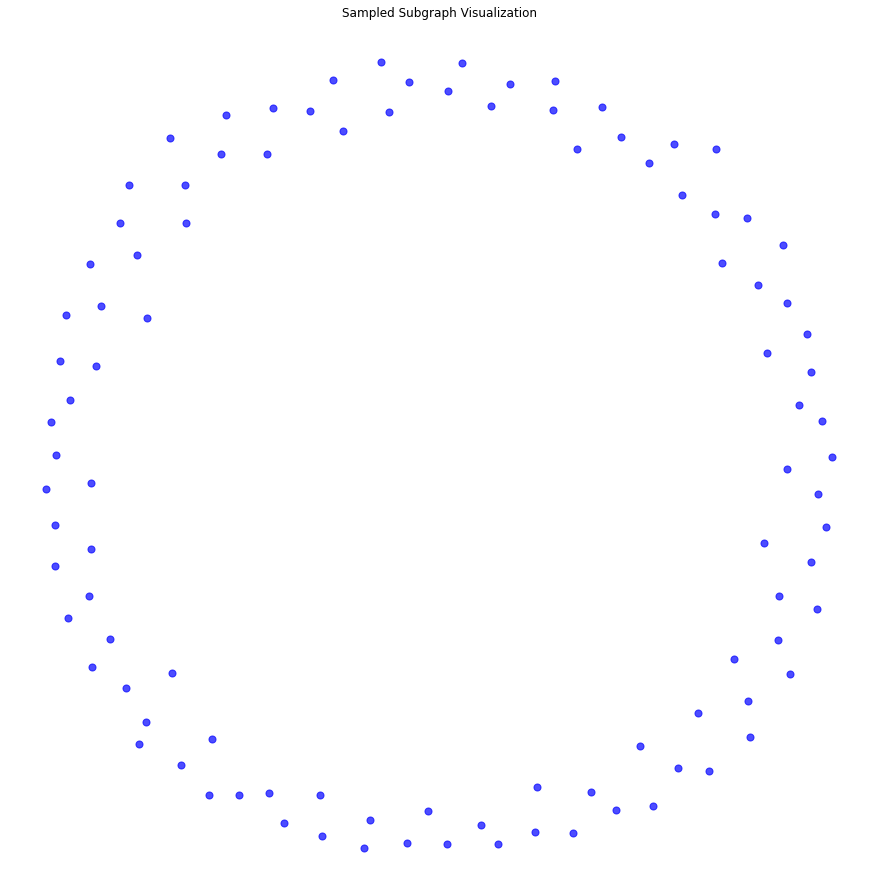

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Convert DGL graph to NetworkX for visualization
nx_graph = g.to_networkx().to_undirected()

# Since the graph is large, we'll take a random sample of nodes for visualization
sample_size = 100  # number of nodes in the sample
sampled_nodes = random.sample(nx_graph.nodes(), sample_size)
subgraph = nx_graph.subgraph(sampled_nodes)

# Visualize the subgraph
plt.figure(figsize=(12, 12))
nx.draw(subgraph, with_labels=False, node_size=50, node_color="blue", alpha=0.7, edge_color="gray")
plt.title("Sampled Subgraph Visualization")
plt.show()


In [ ]:
import dgl
import torch

# Create a graph with 3 nodes and 4 edges
u = torch.tensor([0, 0, 0, 1])  # Source nodes
v = torch.tensor([1, 2, 3, 3])  # Destination nodes
g = dgl.graph((u, v))


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
# Add node features
g.ndata['feature'] = torch.randn(3, 5)  # 3 nodes with 5 features each

# Add edge features
g.edata['weight'] = torch.randn(4, 2)  # 4 edges with 2 features each


DGLError: Expect number of features to match number of nodes (len(u)). Got 3 and 4 instead.

In [ ]:
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, h_feats)
        self.conv2 = dglnn.GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = F.relu(self.conv1(g, in_feat))
        h = self.conv2(g, h)
        return h
